In [1]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [543]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pd_target=0.4,
    dm_target=0.01,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial',
    prop_hug=0.5,
    projection_method='qr',
    metropolised=False,
    δadaptation_method='ap',
    prop_esjd=0.95,
    adaptiveB=False,
    Bmin=5,
    Bmax=100,
    proxy_ap_metric='dm',
    adaptiveN=False,
    NBbudget=None,
    Badaptation_method=None):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [4]:
N      = 500
B      = 30
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1

In [8]:
θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
ystar     = data_generator(θ0, m, seed=seed)  # Observed data
q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
resetwarnings()
manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

def generate_initial_points(ε=200, δ=0.4, N=N, mult=100):
    # Generate target distribution
    logηε = manifold.generate_logηε(ε=200)
    # Find initial point
    x0 = manifold.sample(advanced=True, fromtheta=True)
    # Sample starting from x0
    samples, acceptances = RWM(x0, s=δ, N=N*mult, logpi=logηε)
    print("AP: {:.3f}".format(np.mean(acceptances)*100))
    return samples[::mult]
ε_PARTICLES = 200.0
X_PARTICLES = generate_initial_points(ε=ε_PARTICLES)
V_PARTICLES = np.random.randn(*X_PARTICLES.shape)
PARTICLES   = np.hstack((X_PARTICLES, V_PARTICLES))

AP: 25.782


Alternative way to generate particles.

1. Run MS for the first time until $\epsilon=100$, say, with $\epsilon$ adaptive.
2. Grab the $\epsilon$ values
3. Run MS again with $\epsilon$ fixed to the sequence above plus $\epsilon=100$ and see what happens.

In [288]:
FIRST_RUN = MSAdaptive(generate_settings(d=d, N=N, B=100,
    δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
    z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='prior',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, εmin=500.0))
_ = FIRST_RUN.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 100061937634.9454345703125000
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 69298882.8048191070556641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7720000000000000
	Particle Diversity: 0.5940000000000000
	Moved Diversity: 0.4585680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 6647133.8287100531160831
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3995040000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 519824.3238139905151911
	Weights computed 

In [312]:
SECOND_RUN = MSAdaptive(generate_settings(d=d, N=N, B=100,
    δ=0.1, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=np.array([*FIRST_RUN.εs, 200]), adaptiveε=False, adaptiveδ=True,
    z0_manual=FIRST_RUN.starting_particles, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='manual',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method='ap', εmin=200.0, proxy_ap_metric='pm'))
SECOND_PARTICLES = SECOND_RUN.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 69298882.8048191070556641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0860000000000000
	Particle Diversity: 0.6020000000000000
	Moved Diversity: 0.0517720000000000
	Step-size adapted to: 0.0930530895811206 with strategy ap
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 6647133.8287100531160831
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9060000000000000
	Particle Diversity: 0.3740000000000000
	Moved Diversity: 0.3388440000000000
	Step-size adapted to: 0.1304735058686928 with strategy ap
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 519824.3238139905151911
	Weights computed and normalized.
	SMC Weights compute

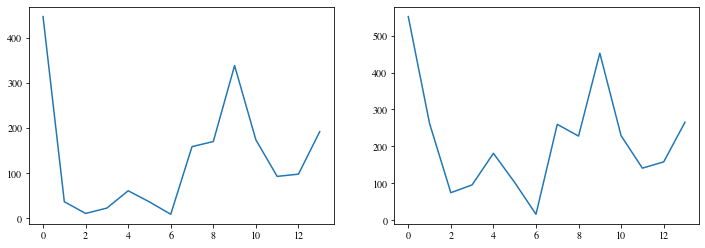

In [313]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(SECOND_RUN.ESS_SMC[1:])
ax[1].plot(SECOND_RUN.ESS[1:])
plt.show()

Do the same but for $5000$ particles

In [371]:
FIRST_RUN10k = MSAdaptive(generate_settings(d=d, N=10000, B=5,
    δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
    z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='prior',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, εmin=500.0))
_ = FIRST_RUN10k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 6446696817851.2958984375000000
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 70606773.8396144509315491
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7297000000000000
	Particle Diversity: 12.0540000000000003
	Moved Diversity: 8.7958037999999998
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5969976.1147064408287406
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8308000000000000
	Particle Diversity: 12.0160000000000000
	Moved Diversity: 9.9828928000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1360340.9406054175924510
	Weights compu

In [372]:
SECOND_RUN10k = MSAdaptive(generate_settings(d=d, N=10000, B=20,
    δ=0.1, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=np.array([*FIRST_RUN10k.εs, 200]), adaptiveε=False, adaptiveδ=True,
    z0_manual=FIRST_RUN10k.starting_particles, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='manual',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method='ap', εmin=200.0, proxy_ap_metric='pm'))
SECOND_PARTICLES10k = SECOND_RUN10k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 70606773.8396144509315491
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0988000000000000
	Particle Diversity: 12.1319999999999997
	Moved Diversity: 1.1986416000000000
	Step-size adapted to: 0.0936505391537791 with strategy ap
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5969976.1147064408287406
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8885000000000000
	Particle Diversity: 7.3419999999999996
	Moved Diversity: 6.5233669999999995
	Step-size adapted to: 0.1301672531178237 with strategy ap
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1360340.9406054175924510
	Weights computed and normalized.
	SMC Weights compu

Do it again, just to get some more 10k particles from the same initial batch, this will give us 20k. Then I'll do it one more time and grab 5k of them.

In [729]:
SECOND_RUN10k_NEW = MSAdaptive(generate_settings(d=d, N=10000, B=20,
    δ=0.1, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=np.array([*FIRST_RUN10k.εs, 200]), adaptiveε=False, adaptiveδ=True,
    z0_manual=FIRST_RUN10k.starting_particles, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='manual',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method='ap', εmin=200.0, proxy_ap_metric='pm'))
SECOND_PARTICLES10k_NEW = SECOND_RUN10k_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 70606773.8396144509315491
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0988000000000000
	Particle Diversity: 0.6066000000000000
	Moved Diversity: 0.0599320800000000
	Step-size adapted to: 0.0936505391537791 with strategy ap
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5969976.1147064408287406
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8942000000000000
	Particle Diversity: 0.3724000000000000
	Moved Diversity: 0.3330000800000000
	Step-size adapted to: 0.1305387589335339 with strategy ap
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1360340.9406054175924510
	Weights computed and normalized.
	SMC Weights comput

DO IT ONE MORE TIME

In [734]:
SECOND_RUN10k_NEW_NEW = MSAdaptive(generate_settings(d=d, N=10000, B=20,
    δ=0.1, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=np.array([*FIRST_RUN10k.εs, 200]), adaptiveε=False, adaptiveδ=True,
    z0_manual=FIRST_RUN10k.starting_particles, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='manual',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method='ap', εmin=200.0, proxy_ap_metric='pm'))
SECOND_PARTICLES10k_NEW_NEW = SECOND_RUN10k_NEW_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 70606773.8396144509315491
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0988000000000000
	Particle Diversity: 0.6066000000000000
	Moved Diversity: 0.0599320800000000
	Step-size adapted to: 0.0936505391537791 with strategy ap
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5969976.1147064408287406
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Particle Diversity: 0.2094000000000000
	Moved Diversity: 0.1993488000000000
	Step-size adapted to: 0.1343663716694189 with strategy ap
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1360340.9406054175924510
	Weights computed and normalized.
	SMC Weights comput

Same but for 12500k

In [540]:
FIRST_RUN12500 = MSAdaptive(generate_settings(d=d, N=12500, B=4,
    δ=0.01, δmin=δmin, min_pm=(1/12500), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
    z0_manual=None, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='prior',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, εmin=500.0,
    adaptiveB=False, Badaptation_method=None))
_ = FIRST_RUN12500.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Setting initial epsilon to εmax = 11693834392253.5976562500000000
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 69156161.2948447912931442
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6915200000000000
	Particle Diversity: 0.5994400000000000
	Moved Diversity: 0.4145247488000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5713455.0202694954350591
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7987200000000000
	Particle Diversity: 0.6067200000000000
	Moved Diversity: 0.4845993984000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1133380.8307253313250840
	Weights comput

In [542]:
SECOND_RUN12500 = MSAdaptive(generate_settings(d=d, N=12500, B=10,
    δ=0.1, δmin=δmin, min_pm=(1/12500), verbose=True, εs_fixed=np.array([*FIRST_RUN12500.εs, 200]), adaptiveε=False, adaptiveδ=True,
    z0_manual=FIRST_RUN12500.starting_particles, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
    εprop_switch=0.01, ε0_manual=None, quantile_value=0.9, initialization='manual',
    switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
    resampling_scheme='multinomial', maxiter=500, δadaptation_method='ap', εmin=200.0, proxy_ap_metric='pm',
    adaptiveB=False, Badaptation_method=None))
SECOND_PARTICLES12500 = SECOND_RUN12500.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 69156161.2948447912931442
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1035200000000000
	Particle Diversity: 0.6036000000000000
	Moved Diversity: 0.0624846720000000
	Step-size adapted to: 0.0938718154294857 with strategy ap
Iteration:  2
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 5713455.0202694954350591
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8848800000000000
	Particle Diversity: 0.3896000000000000
	Moved Diversity: 0.3447492480000000
	Step-size adapted to: 0.1302388647984455 with strategy ap
Iteration:  3
	Quantile Value:  0.9
	Trajectories constructed.
	Epsilon: 1133380.8307253313250840
	Weights computed and normalized.
	SMC Weights comput

# The need to adapt $B$ and $\delta$

To show the need to adapt $B$ and $\delta$ run MS with $\delta$ fixed and a fairly large $B$, for a suitable step size. We will then grab ESJD-BR and show how this has a maximum at different $k\in\{0, T\}$ as the iteration progresses.

In [14]:
LOL = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None))
_ = LOL.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3920000000000000
	Moved Diversity: 0.3825920000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.8030587859000846
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9680000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.38

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.3560960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  27
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6182806201689122
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8280000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3361680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  28
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4779304154824833
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8020000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.3288200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  29
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3367060740548533
	Weights computed and 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4740000000000000
	Particle Diversity: 0.4540000000000000
	Moved Diversity: 0.2151960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  53
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8859374314814383
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5080000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.2194560000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  54
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8689133822522641
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4560000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2006400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  55
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8543961095220696
	Weights computed and 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4760000000000000
	Particle Diversity: 0.4680000000000000
	Moved Diversity: 0.2227680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  79
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2211639842578554
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5300000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2257800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  80
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1877591053503813
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2387000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  81
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1514942911846893
	Weights computed and 

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.0760760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  105
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7258403435179728
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3120000000000000
	Particle Diversity: 0.3000000000000000
	Moved Diversity: 0.0936000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  106
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7152125575341326
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2240000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.0918400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  107
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7017069431365826
	Weights computed a

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1100000000000000
	Particle Diversity: 0.1620000000000000
	Moved Diversity: 0.0178200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  131
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5369165454866824
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0640000000000000
	Particle Diversity: 0.1200000000000000
	Moved Diversity: 0.0076800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  132
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5333265117757682
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0600000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.0267600000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5242440666853849
	Weights computed a

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Diversity: 0.0940000000000000
	Moved Diversity: 0.0240640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  157
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4034690989029133
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0300000000000000
	Particle Diversity: 0.3580000000000000
	Moved Diversity: 0.0107400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  158
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4001794707255762
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0720000000000000
	Particle Diversity: 0.1960000000000000
	Moved Diversity: 0.0141120000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  159
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3967064515090321
	Weights computed a

Now plot snapshows of the ESJD at different run iterations

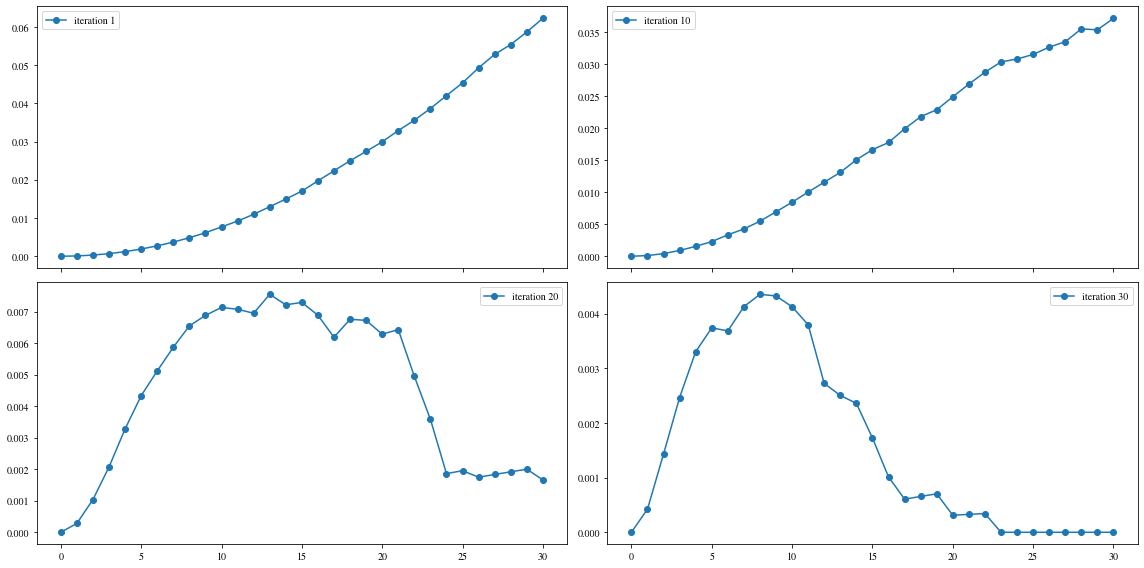

In [199]:
rc('font',**{'family':'STIXGeneral'})
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True)
# (0, 0) iteration 1
ax[0, 0].plot(np.arange(B+1), LOL.ESJD_CHANG[1], marker='o', label="iteration 1")
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 0].hist(LOL.K_RESAMPLED[1], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 0].set_xticks(np.arange(LOL.B+1))
ax[0, 0].legend()
# (0, 1) iteration 25
ax[0, 1].plot(np.arange(B+1), LOL.ESJD_CHANG[10], marker='o', label='iteration 10')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 1].hist(LOL.K_RESAMPLED[10], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 1].set_xticks(np.arange(LOL.B+1))
ax[0, 1].legend()
# (1, 0) iteration 75
ax[1, 0].plot(np.arange(B+1), LOL.ESJD_CHANG[20], marker='o', label='iteration 20')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 0].hist(LOL.K_RESAMPLED[20], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 0].set_xticks(np.arange(LOL.B+1))
ax[1, 0].legend()
# (1, 1) iteration 100
ax[1, 1].plot(np.arange(B+1), LOL.ESJD_CHANG[30], marker='o', label='iteration 30')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 1].hist(LOL.K_RESAMPLED[30], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 1].set_xticks(np.arange(LOL.B+1))
ax[1, 1].legend()
plt.tight_layout()
plt.show()

In the plots above we can see that indeed there is a maximum Expected Squared Jump Distance, which explains the need for adapting $B$ and $\delta$.

Let's try to get a similar plot but now let's run the algorithm with larger $B$ to see what happens at the very beginning. 

In [201]:
LOL_LONG = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=False, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None))
_ = LOL_LONG.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.3396479999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.9341338734060614
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.3120000000000000
	Moved Diversity: 0.3057600000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.1051403329597704
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3386399999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8422490527730018
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8440000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.3494159999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6184662665673741
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8159999999999999
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.3394560000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Trajectories constructed.
	Epsilon: 0.9803243606877594
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4160000000000000
	Particle Diversity: 0.4520000000000000
	Moved Diversity: 0.1880320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9481034615692534
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4140000000000000
	Particle Diversity: 0.4480000000000000
	Moved Diversity: 0.1854720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9238526484170677
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3380000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.1493960

	Trajectories constructed.
	Epsilon: 0.7138322472828209
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0340000000000000
	Particle Diversity: 0.5080000000000000
	Moved Diversity: 0.0172720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7111114429874437
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0320000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.0136320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7065708608478120
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0640000000000000
	Particle Diversity: 0.2640000000000000
	Moved Diversity: 0.0168960

AttributeError: 'Rectangle' object has no property 'marker'

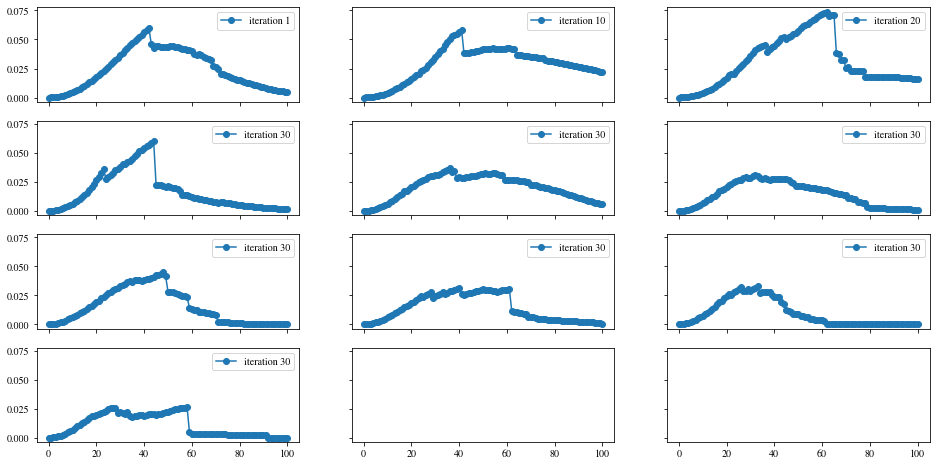

In [218]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX1], marker='o', label="iteration 1")
ax[0, 0].legend()

ax[0, 1].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX2], marker='o', label='iteration 10')
ax[0, 1].legend()

ax[0, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX3], marker='o', label='iteration 20')
ax[0, 2].legend()

ax[1, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX4], marker='o', label='iteration 30')
ax[1, 0].legend()

ax[1, 1].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX5], marker='o', label='iteration 30')
ax[1, 1].legend()

ax[1, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX6], marker='o', label='iteration 30')
ax[1, 2].legend()

ax[2, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX7], marker='o', label='iteration 30')
ax[2, 0].legend()

ax[2, 1].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX8], marker='o', label='iteration 30')
ax[2, 1].legend()

ax[2, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX9], marker='o', label='iteration 30')
ax[2, 2].legend()

ax[3, 0].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX10], marker='o', label='iteration 30')
ax[3, 0].legend()

ax[3, 1].pl0t(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX11], marker='o', label='iteration 30')
ax[3, 1].legend()

ax[3, 2].plot(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX12], marker='o', label='iteration 30')
ax[3, 2].legend()

plt.tight_layout()
# plt.savefig("figures/gk20_esjd_over_k_for_B100.png")
plt.show()

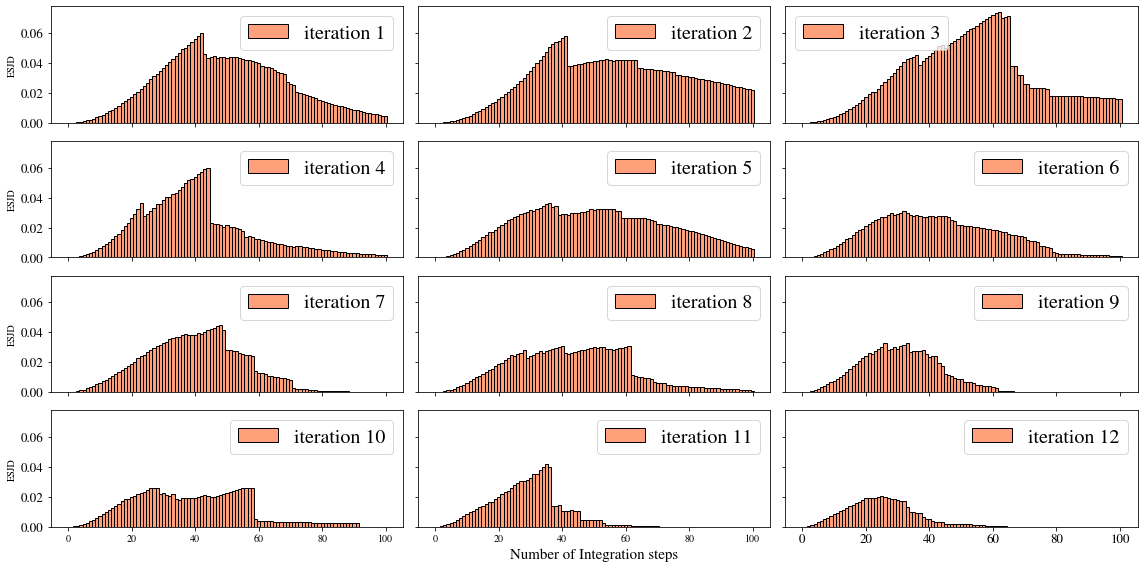

In [255]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX1], width=1.0, edgecolor='k', color='lightsalmon', label="iteration 1")
ax[0, 0].legend(fontsize=20)
ax[0, 0].yaxis.set_tick_params(labelsize=13) 
ax[0, 0].set_ylabel("ESJD")

ax[0, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX2], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 2')
ax[0, 1].legend(fontsize=20)

ax[0, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX3], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 3')
ax[0, 2].legend(fontsize=20)
ax[0, 2].xaxis.set_tick_params(labelsize=13) 

ax[1, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX4], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 4')
ax[1, 0].legend(fontsize=20)
ax[1, 0].yaxis.set_tick_params(labelsize=13) 
ax[1, 0].set_ylabel("ESJD")

ax[1, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX5], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 5')
ax[1, 1].legend(fontsize=20)

ax[1, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX6], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 6')
ax[1, 2].legend(fontsize=20)
ax[1, 2].xaxis.set_tick_params(labelsize=13) 

ax[2, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX7], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 7')
ax[2, 0].legend(fontsize=20)
ax[2, 0].yaxis.set_tick_params(labelsize=13) 
ax[2, 0].set_ylabel("ESJD")

ax[2, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX8], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 8')
ax[2, 1].legend(fontsize=20)

ax[2, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX9], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 9')
ax[2, 2].legend(fontsize=20)
ax[2, 2].xaxis.set_tick_params(labelsize=13) 

ax[3, 0].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX10], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 10')
ax[3, 0].legend(fontsize=20)
ax[3, 0].yaxis.set_tick_params(labelsize=13) 
ax[3, 0].set_ylabel("ESJD")

ax[3, 1].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX11], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 11')
ax[3, 1].legend(fontsize=20)
ax[3, 1].set_xlabel("Number of Integration steps", fontsize=15)

ax[3, 2].bar(np.arange(LOL_LONG.B+1), LOL_LONG.ESJD_CHANG[INDEX12], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 12')
ax[3, 2].legend(fontsize=20)
ax[3, 2].xaxis.sett_tick_params(labelsize=13) 

plt.tight_layout()
plt.savefig("figures/gk20_esjd_over_k_for_B100_firstfew.png")
plt.show()

The epsilons for this setting are shown below.

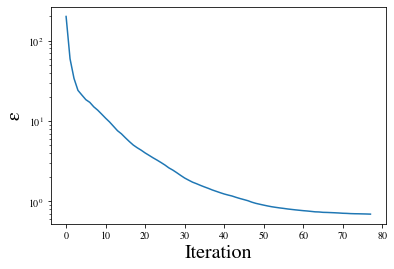

In [258]:
fig, ax = plt.subplots()
ax.plot(LOL_LONG.εs)
ax.set_yscale('log')
ax.set_ylabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_xlabel("Iteration", fontsize=20)
plt.show()

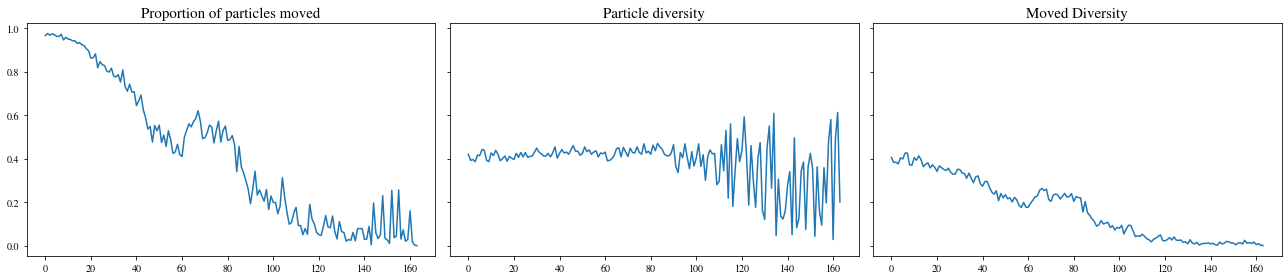

In [259]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharex=True, sharey=True)
ax[0].plot(LOL.PROP_MOVED[1:])
ax[0].set_title("Proportion of particles moved", fontsize=15)
ax[1].plot(LOL.P_DIVERSITY[1:])
ax[1].set_title("Particle diversity", fontsize=15)
ax[2].plot(LOL.DIV_MOVED[1:])
ax[2].set_title("Moved Diversity", fontsize=15)
plt.tight_layout()
plt.show()

# Adapting $B$ and $\delta$ based on ESJD and PM

In [178]:
LOL2 = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100))
_ = LOL2.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	 RWM Integrator with B = 30 and δ = 0.010000
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Increasing B=43 and keeping δ=0.01 fixed.
	Step-size adapted to: 0.0100000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 43
Iteration:  2
	Quantile Value:  0.5
	 RWM Integrator with B = 43 and δ = 0.010000
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.3660000000000000
	Moved Diversity: 0.3550200000000000
	Increasing B=62 and keeping δ=0.01 fixed.
	S

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0552000000000000
	Step-size adapted to: 0.1808583570346251 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  19
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.180858
	Trajectories constructed.
	Epsilon: 7.1261947089418323
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1220000000000000
	Particle Diversity: 0.4660000000000000
	Moved Diversity: 0.0568520000000000
	Step-size adapted to: 0.1713510141837691 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  20
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.171351
	Trajectories constructed.
	Epsilon: 6.7154714128210946
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1280000000000000
	Particle Diversity: 0.2840000000000000
	Moved Diversity: 0.0363520000000000
	Step-size adapted to: 0.0728727061072574 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  37
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.072873
	Trajectories constructed.
	Epsilon: 2.6034321004071872
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0980000000000000
	Particle Diversity: 0.2620000000000000
	Moved Diversity: 0.0256760000000000
	Step-size adapted to: 0.0682183893514560 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  38
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.068218
	Trajectories constructed.
	Epsilon: 2.4409699630877331
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0900000000000000
	Particle Diversity: 0.4700000000000000
	Moved Diversity: 0.0423000000000000
	Step-size adapted to: 0.0226399074875543 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  55
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.022640
	Trajectories constructed.
	Epsilon: 1.5947934789834053
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0920000000000000
	Particle Diversity: 0.3500000000000000
	Moved Diversity: 0.0322000000000000
	Step-size adapted to: 0.0211304296926367 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  56
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.021130
	Trajectories constructed.
	Epsilon: 1.5720564801657961
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0860000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.0378400000000000
	Step-size adapted to: 0.0096091346018231 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.009609
	Trajectories constructed.
	Epsilon: 1.3882971207318586
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2020000000000000
	Particle Diversity: 0.3540000000000000
	Moved Diversity: 0.0715080000000000
	Step-size adapted to: 0.0094755440333491 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.009476
	Trajectories constructed.
	Epsilon: 1.3820522498835817
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1920000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.0879360000000000
	Step-size adapted to: 0.0053855215974018 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  91
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005386
	Trajectories constructed.
	Epsilon: 1.3333843089381459
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2140000000000000
	Particle Diversity: 0.3460000000000000
	Moved Diversity: 0.0740440000000000
	Step-size adapted to: 0.0053426093026669 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  92
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005343
	Trajectories constructed.
	Epsilon: 1.3310510841252636
	Weights computed and normalized.
	SMC Weights computed and normalized.
	P

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1500000000000000
	Particle Diversity: 0.3600000000000000
	Moved Diversity: 0.0540000000000000
	Step-size adapted to: 0.0056446837166107 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  109
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005645
	Trajectories constructed.
	Epsilon: 1.2835956283041616
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.0815920000000000
	Step-size adapted to: 0.0055273813443016 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  110
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.005527
	Trajectories constructed.
	Epsilon: 1.2807909131541864
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2600000000000000
	Particle Diversity: 0.3640000000000000
	Moved Diversity: 0.0946400000000000
	Step-size adapted to: 0.0044848908883506 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  127
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004485
	Trajectories constructed.
	Epsilon: 1.2437752245267226
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1740000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.0734280000000000
	Step-size adapted to: 0.0043610557262050 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  128
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004361
	Trajectories constructed.
	Epsilon: 1.2423983438138000
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2060000000000000
	Particle Diversity: 0.4520000000000000
	Moved Diversity: 0.0931120000000000
	Step-size adapted to: 0.0040177183508648 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  145
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004018
	Trajectories constructed.
	Epsilon: 1.2065058130759494
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2100000000000000
	Particle Diversity: 0.3920000000000000
	Moved Diversity: 0.0823200000000000
	Step-size adapted to: 0.0039777413853247 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  146
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003978
	Trajectories constructed.
	Epsilon: 1.2049079571498846
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1780000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0818800000000000
	Step-size adapted to: 0.0034236737385050 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  163
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003424
	Trajectories constructed.
	Epsilon: 1.1822114706516194
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1540000000000000
	Particle Diversity: 0.3660000000000000
	Moved Diversity: 0.0563640000000000
	Step-size adapted to: 0.0032960150134481 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  164
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003296
	Trajectories constructed.
	Epsilon: 1.1813359621615778
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2300000000000000
	Particle Diversity: 0.3680000000000000
	Moved Diversity: 0.0846400000000000
	Step-size adapted to: 0.0031415432720321 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  181
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003142
	Trajectories constructed.
	Epsilon: 1.1641666105867530
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.0889440000000000
	Step-size adapted to: 0.0031227504472527 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  182
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003123
	Trajectories constructed.
	Epsilon: 1.1632401756892770
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1240000000000000
	Particle Diversity: 0.5300000000000000
	Moved Diversity: 0.0657200000000000
	Step-size adapted to: 0.0027946703784819 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  199
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002795
	Trajectories constructed.
	Epsilon: 1.1455806925964276
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.0849720000000000
	Step-size adapted to: 0.0027448163440310 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  200
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002745
	Trajectories constructed.
	Epsilon: 1.1447690515314042
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2400000000000000
	Particle Diversity: 0.3720000000000000
	Moved Diversity: 0.0892800000000000
	Step-size adapted to: 0.0045344970216615 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  217
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004534
	Trajectories constructed.
	Epsilon: 1.1085282124379090
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2760000000000000
	Particle Diversity: 0.4440000000000000
	Moved Diversity: 0.1225440000000000
	Step-size adapted to: 0.0046399990759427 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  218
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.004640
	Trajectories constructed.
	Epsilon: 1.1052731158900531
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2880000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1146240000000000
	Step-size adapted to: 0.0071471535109898 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  235
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.007147
	Trajectories constructed.
	Epsilon: 1.0198545915133819
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2440000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.1005280000000000
	Step-size adapted to: 0.0071973591001227 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  236
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.007197
	Trajectories constructed.
	Epsilon: 1.0106609713125136
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2020000000000000
	Particle Diversity: 0.3840000000000000
	Moved Diversity: 0.0775680000000000
	Step-size adapted to: 0.0086513395228536 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  253
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.008651
	Trajectories constructed.
	Epsilon: 0.8032102547070250
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1320000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.0588720000000000
	Increasing B=5 and keeping δ=0.008651339522853579 fixed.
	Step-size adapted to: 0.0086513395228536 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  254
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.008651
	Trajectories constructed.
	Epsilon: 0.7923748232593502
	Weights compu

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1300000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.0546000000000000
	Step-size adapted to: 0.0063771045820935 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  271
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.006377
	Trajectories constructed.
	Epsilon: 0.5937744702018923
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3240000000000000
	Particle Diversity: 0.2520000000000000
	Moved Diversity: 0.0816480000000000
	Step-size adapted to: 0.0066839836666949 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  272
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.006684
	Trajectories constructed.
	Epsilon: 0.5853384162964843
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1480000000000000
	Particle Diversity: 0.3540000000000000
	Moved Diversity: 0.0523920000000000
	Increasing B=5 and keeping δ=0.003879530600592494 fixed.
	Step-size adapted to: 0.0038795306005925 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  289
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003880
	Trajectories constructed.
	Epsilon: 0.5096490463682085
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.0728000000000000
	Step-size adapted to: 0.0037875302859270 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  290
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003788
	Trajectories constructed.
	Epsilon: 0.5066492555810418
	Weights compu

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1360000000000000
	Particle Diversity: 0.4540000000000000
	Moved Diversity: 0.0617440000000000
	Step-size adapted to: 0.0030426053368498 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  307
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.003043
	Trajectories constructed.
	Epsilon: 0.4552752778798773
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1560000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.0624000000000000
	Step-size adapted to: 0.0029320861524078 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  308
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002932
	Trajectories constructed.
	Epsilon: 0.4533817828923647
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2960000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.1000480000000000
	Step-size adapted to: 0.0020890599228080 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  325
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.002089
	Trajectories constructed.
	Epsilon: 0.4272979524238942
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1400000000000000
	Particle Diversity: 0.4760000000000000
	Moved Diversity: 0.0666400000000000
	Step-size adapted to: 0.0019971360256029 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  326
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001997
	Trajectories constructed.
	Epsilon: 0.4264252292613051
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1420000000000000
	Particle Diversity: 0.3560000000000000
	Moved Diversity: 0.0505520000000000
	Step-size adapted to: 0.0015352821375104 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  343
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001535
	Trajectories constructed.
	Epsilon: 0.4124028057095041
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3520000000000000
	Moved Diversity: 0.0767360000000000
	Step-size adapted to: 0.0015260980245765 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  344
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001526
	Trajectories constructed.
	Epsilon: 0.4117393903841560
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2240000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.0985600000000000
	Step-size adapted to: 0.0015569272496851 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  361
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001557
	Trajectories constructed.
	Epsilon: 0.3993247010310311
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2480000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.1006880000000000
	Step-size adapted to: 0.0015710028400790 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  362
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001571
	Trajectories constructed.
	Epsilon: 0.3985377251700223
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2980000000000000
	Particle Diversity: 0.3260000000000000
	Moved Diversity: 0.0971480000000000
	Step-size adapted to: 0.0014899076930838 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  379
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001490
	Trajectories constructed.
	Epsilon: 0.3846800277410473
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2280000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.1026000000000000
	Step-size adapted to: 0.0014884185300963 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  380
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001488
	Trajectories constructed.
	Epsilon: 0.3838454795406727
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2260000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.0935640000000000
	Step-size adapted to: 0.0012836584524114 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  397
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001284
	Trajectories constructed.
	Epsilon: 0.3734706515717416
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Particle Diversity: 0.4720000000000000
	Moved Diversity: 0.0566400000000000
	Step-size adapted to: 0.0012149636602523 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  398
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001215
	Trajectories constructed.
	Epsilon: 0.3730738332364863
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2740000000000000
	Particle Diversity: 0.3840000000000000
	Moved Diversity: 0.1052160000000000
	Step-size adapted to: 0.0013400597025175 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  415
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001340
	Trajectories constructed.
	Epsilon: 0.3619546501201096
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2060000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.0927000000000000
	Step-size adapted to: 0.0013240750856037 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  416
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001324
	Trajectories constructed.
	Epsilon: 0.3614916573747987
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.0736840000000000
	Step-size adapted to: 0.0011825985367502 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  433
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001183
	Trajectories constructed.
	Epsilon: 0.3520384414475489
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1900000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.0809400000000000
	Step-size adapted to: 0.0011591815167770 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  434
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001159
	Trajectories constructed.
	Epsilon: 0.3514435105268853
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3540000000000000
	Particle Diversity: 0.3300000000000000
	Moved Diversity: 0.1168200000000000
	Step-size adapted to: 0.0011980726817434 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  451
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001198
	Trajectories constructed.
	Epsilon: 0.3409329771662409
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3600000000000000
	Particle Diversity: 0.3860000000000000
	Moved Diversity: 0.1389600000000000
	Step-size adapted to: 0.0012785340741907 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  452
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001279
	Trajectories constructed.
	Epsilon: 0.3401753338310944
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2020000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.0803960000000000
	Step-size adapted to: 0.0011603412780778 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  469
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001160
	Trajectories constructed.
	Epsilon: 0.3279711335358007
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2100000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.0919800000000000
	Step-size adapted to: 0.0011487956894532 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  470
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001149
	Trajectories constructed.
	Epsilon: 0.3275398435678551
	Weights computed and normalized.
	SMC Weights computed and normalized.


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2580000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.1037160000000000
	Step-size adapted to: 0.0010800420763926 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  487
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001080
	Trajectories constructed.
	Epsilon: 0.3198074705355859
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Diversity: 0.3800000000000000
	Moved Diversity: 0.0972800000000000
	Step-size adapted to: 0.0010941742837052 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  488
	Quantile Value:  0.5
	 RWM Integrator with B = 5 and δ = 0.001094
	Trajectories constructed.
	Epsilon: 0.3192795046294498
	Weights computed and normalized.
	SMC Weights computed and normalized.


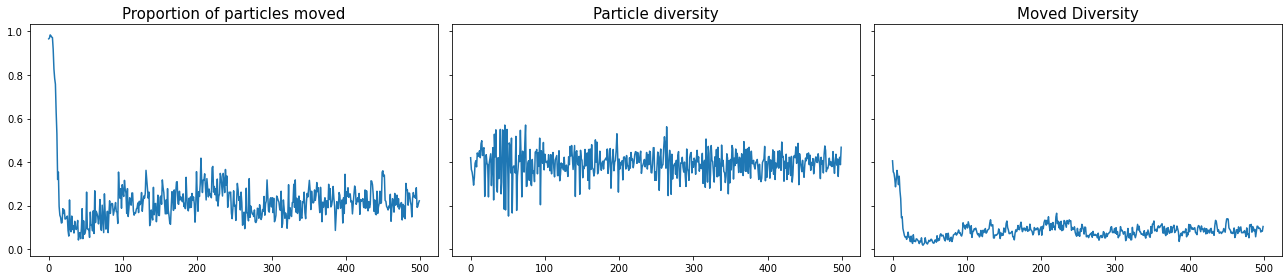

In [179]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharex=True, sharey=True)
ax[0].plot(LOL2.PROP_MOVED[1:])
ax[0].set_title("Proportion of particles moved", fontsize=15)
ax[1].plot(LOL2.P_DIVERSITY[1:])
ax[1].set_title("Particle diversity", fontsize=15)
ax[2].plot(LOL2.DIV_MOVED[1:])
ax[2].set_title("Moved Diversity", fontsize=15)
plt.tight_layout()
plt.show()

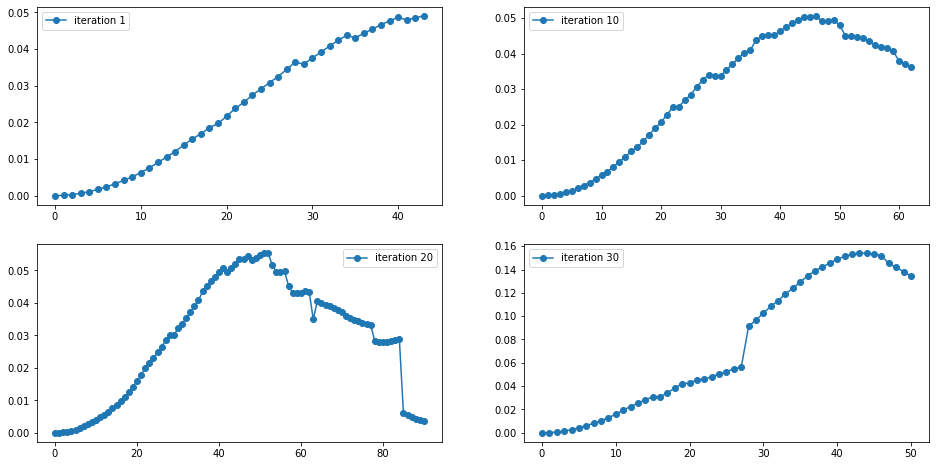

In [186]:
index1 = 1
index2 = 2
index3 = 3
index4 = 4
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
# (0, 0) iteration 1
ax[0, 0].plot(np.arange(LOL2.Bs[index1]+1), LOL2.ESJD_CHANG[1:][index1], marker='o', label="iteration 1")
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 0].hist(LOL.K_RESAMPLED[index1], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 0].set_xticks(np.arange(LOL.B+1))
ax[0, 0].legend()
# (0, 1) iteration 25
ax[0, 1].plot(np.arange(LOL2.Bs[index2]+1), LOL2.ESJD_CHANG[1:][index2], marker='o', label='iteration 10')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[0, 1].hist(LOL.K_RESAMPLED[index2], density=True, edgecolor='k', color='lightsalmon')
# ax[0, 1].set_xticks(np.arange(LOL.B+1))
ax[0, 1].legend()
# (1, 0) iteration 75
ax[1, 0].plot(np.arange(LOL2.Bs[index3]+1), LOL2.ESJD_CHANG[1:][index3], marker='o', label='iteration 20')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 0].hist(LOL.K_RESAMPLED[index3], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 0].set_xticks(np.arange(LOL.B+1))
ax[1, 0].legend()
# (1, 1) iteration 100
ax[1, 1].plot(np.arange(LOL2.Bs[index4]+1), LOL2.ESJD_CHANG[1:][index4], marker='o', label='iteration 30')
# bins = np.arange(start=-0.5, stop=(LOL.B+1), step=1)
# _ = ax[1, 1].hist(LOL.K_RESAMPLED[index4], density=True, edgecolor='k', color='lightsalmon')
# ax[1, 1].set_xticks(np.arange(LOL.B+1))
ax[1, 1].legend()
plt.show()

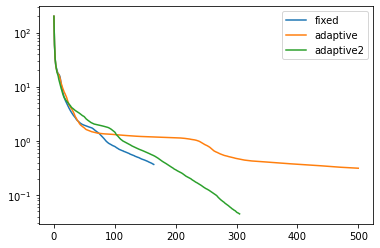

In [191]:
fig, ax = plt.subplots()
ax.plot(LOL.εs, label='fixed')
ax.plot(LOL2.εs, label='adaptive')
ax.plot(LOL3.εs, label='adaptive2')
ax.set_yscale('log')
ax.legend()
plt.show()

In [189]:
LOL3 = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100))
_ = LOL3.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Step-size adapted to: 0.0144484203897388 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3666600000000000
	Step-size adapted to: 0.0209174783254322 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.9020

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0320000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.0139520000000000
	Step-size adapted to: 0.1100596464826380 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  22
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.2379696533497926
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0720000000000000
	Particle Diversity: 0.5520000000000000
	Moved Diversity: 0.0397440000000000
	Step-size adapted to: 0.1016995074202697 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0599136191381815
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0960000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3980000000000000
	Particle Diversity: 0.1760000000000000
	Moved Diversity: 0.0700480000000000
	Step-size adapted to: 0.0491080248125934 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  42
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2428156866898026
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1460000000000000
	Particle Diversity: 0.3520000000000000
	Moved Diversity: 0.0513920000000000
	Step-size adapted to: 0.0470882009763995 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  43
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1734579079718008
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2860000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1900000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.0752400000000000
	Step-size adapted to: 0.0287610620324045 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  62
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1558891029580729
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3320000000000000
	Moved Diversity: 0.0723760000000000
	Step-size adapted to: 0.0285890123254796 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  63
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1272336146746165
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1320000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2900000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.1009200000000000
	Step-size adapted to: 0.0132768572022583 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  82
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8650336259623588
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2000000000000000
	Particle Diversity: 0.4920000000000000
	Moved Diversity: 0.0984000000000000
	Step-size adapted to: 0.0130791905503496 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  83
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8514226890966741
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2320000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2920000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.1249760000000000
	Step-size adapted to: 0.0191063828448285 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3374624146177565
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2200000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.0915200000000000
	Step-size adapted to: 0.0190110893628373 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2934035597147271
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2100000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1980000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.0744480000000000
	Step-size adapted to: 0.0101454208873099 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8866841890686348
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1800000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.0784800000000000
	Step-size adapted to: 0.0098949295530926 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  123
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8752367910739605
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1400000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1780000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.0669280000000000
	Step-size adapted to: 0.0065996885569910 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  142
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6876669992778709
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4660000000000000
	Moved Diversity: 0.0848120000000000
	Step-size adapted to: 0.0064431816270431 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  143
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6798239856679480
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1700000000000000
	Particle Diversity: 0.3900000000000000
	Moved Diversity: 0.0663000000000000
	Step-size adapted to: 0.0050431075002033 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5484054298533596
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880000000000000
	Particle Diversity: 0.3820000000000000
	Moved Diversity: 0.0718160000000000
	Step-size adapted to: 0.0049383065045615 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5422710230395273
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2200000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2840000000000000
	Particle Diversity: 0.3040000000000000
	Moved Diversity: 0.0863360000000000
	Step-size adapted to: 0.0046090532151110 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  182
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3951784476752459
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1380000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.0552000000000000
	Step-size adapted to: 0.0044018392264010 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  183
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3887284025369460
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1380000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2440000000000000
	Particle Diversity: 0.3700000000000000
	Moved Diversity: 0.0902800000000000
	Step-size adapted to: 0.0034904213499940 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2852399368350662
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1120000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.0463680000000000
	Step-size adapted to: 0.0032904438338498 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  203
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2803339813078723
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1640000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.0760760000000000
	Step-size adapted to: 0.0022524588901867 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  222
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2094540914297515
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1440000000000000
	Particle Diversity: 0.3180000000000000
	Moved Diversity: 0.0457920000000000
	Step-size adapted to: 0.0021576560265676 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  223
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2076380571355483
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1980000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2000000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.0676000000000000
	Step-size adapted to: 0.0017298288268279 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  242
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1512692759211098
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2360000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.0991200000000000
	Step-size adapted to: 0.0017350261053282 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  243
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1482612894655984
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3240000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2240000000000000
	Particle Diversity: 0.3580000000000000
	Moved Diversity: 0.0801920000000000
	Step-size adapted to: 0.0012436149983813 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  262
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1081844579863711
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2560000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.1044480000000000
	Step-size adapted to: 0.0012598875356818 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  263
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1062451687824844
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2720000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1780000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.0801000000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  282
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0696515275174148
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2120000000000000
	Particle Diversity: 0.3380000000000000
	Moved Diversity: 0.0716560000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  283
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0681401594291297
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0120000000000000
	Particle Diversity: 0.5900000000000000
	Moved Diversity: 0.0070800000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  302
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0472436056340810
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1160000000000000
	Particle Diversity: 0.1320000000000000
	Moved Diversity: 0.0153120000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  303
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.0466154165338100
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0060000000000000
	Particle Div

In [197]:
LOL4 = MSAdaptive(generate_settings(d=d, N=N, B=B,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.01, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='dm'))
_ = LOL4.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.4057200000000000
	Step-size adapted to: 0.0121879175103178 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.1886107756514690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9580000000000000
	Particle Diversity: 0.3680000000000000
	Moved Diversity: 0.3525440000000000
	Step-size adapted to: 0.0144647852623904 with strategy esjd_and_pm
	Number of steps adapted to: 30
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.7682

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1280000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.0524800000000000
	Step-size adapted to: 0.1475765601515626 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  22
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.7785093853914180
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0920000000000000
	Particle Diversity: 0.4780000000000000
	Moved Diversity: 0.0439760000000000
	Step-size adapted to: 0.1501050065721249 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5353014310922202
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1140000000000000
	Particle Diver

# Adapt B and $\delta$ but first start from huge B so we only need to decrease it

In [260]:
# adapt B and δ based on EJSD and PM
LOL_LONG_ADAPT = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd_and_pm', adaptiveB=True,
        Bmin=5, Bmax=100))
_ = LOL_LONG_ADAPT.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.3396479999999999
	Step-size adapted to: 0.0105635467989005 with strategy esjd_and_pm
	Number of steps adapted to: 80
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.9341338734060614
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9820000000000000
	Particle Diversity: 0.2940000000000000
	Moved Diversity: 0.2887080000000000
	Step-size adapted to: 0.0108782250898316 with strategy esjd_and_pm
	Number of steps adapted to: 71
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.6848

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7100000000000000
	Particle Diversity: 0.3840000000000000
	Moved Diversity: 0.2726400000000000
	Step-size adapted to: 0.0314390607576446 with strategy esjd_and_pm
	Number of steps adapted to: 10
Iteration:  22
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.0321293728467893
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7400000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.2989600000000000
	Step-size adapted to: 0.0325419847142750 with strategy esjd_and_pm
	Number of steps adapted to: 9
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.5245570937149511
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7220000000000000
	Particle Dive

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3900000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1638000000000000
	Step-size adapted to: 0.0253820718719271 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  42
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7048070550362282
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4480000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1881600000000000
	Step-size adapted to: 0.0248565945850839 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  43
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6553299385099800
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3700000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5020000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.2088320000000000
	Step-size adapted to: 0.0147474338738176 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  62
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0923670824880478
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4740000000000000
	Particle Diversity: 0.4440000000000000
	Moved Diversity: 0.2104560000000000
	Step-size adapted to: 0.0146040237928658 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  63
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0735990213664728
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4820000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6020000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.2540440000000000
	Step-size adapted to: 0.0147049047264385 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  82
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2681556942744088
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5280000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2291520000000000
	Step-size adapted to: 0.0146986711684422 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  83
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2203881011974937
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5220000000000000
	Particle Diver

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4500000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.1881000000000000
	Step-size adapted to: 0.0108387436840976 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7496044445172056
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3660000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.1588440000000000
	Step-size adapted to: 0.0104599020358358 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7355766461969897
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4160000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4060000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.1778280000000000
	Step-size adapted to: 0.0062189251913047 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5451903338903699
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4340000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.1857520000000000
	Step-size adapted to: 0.0060828485209244 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  123
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5391618329915273
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4340000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4640000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.2050880000000000
	Step-size adapted to: 0.0039415777723808 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  142
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4468592570345895
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5100000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.2111400000000000
	Step-size adapted to: 0.0039045833966120 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  143
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4417992484431155
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4820000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Diversity: 0.4440000000000000
	Moved Diversity: 0.2326560000000000
	Step-size adapted to: 0.0032147483888501 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3682503004748916
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5100000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.2233800000000000
	Step-size adapted to: 0.0032041251628212 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3643540218001196
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4960000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5180000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2248120000000000
	Step-size adapted to: 0.0028167876177556 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  182
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3152805422535070
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4940000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.2124200000000000
	Step-size adapted to: 0.0027921365547375 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  183
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3127196767892904
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4320000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.2244000000000000
	Step-size adapted to: 0.0027083107281782 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  202
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2584152969539419
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4700000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.1927000000000000
	Step-size adapted to: 0.0026582688243178 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  203
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2554363147618528
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5700000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.2382600000000000
	Step-size adapted to: 0.0025836912487256 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  222
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1968308438518545
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5060000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2226400000000000
	Step-size adapted to: 0.0025742007381800 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  223
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1934215369455936
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5280000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5160000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.2146560000000000
	Step-size adapted to: 0.0023964466865598 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  242
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1435869245263748
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5120000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.2119680000000000
	Step-size adapted to: 0.0023749374326543 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  243
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1407236951562605
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4900000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5320000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2276960000000000
	Step-size adapted to: 0.0021808988165415 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  262
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0964771661702650
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2242720000000000
	Step-size adapted to: 0.0021746616582050 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  263
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0928997540440222
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5540000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6740000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.2938640000000000
	Step-size adapted to: 0.0024558454799947 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  282
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0310798281381990
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5880000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.2681280000000000
	Step-size adapted to: 0.0025031128391461 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  283
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0252904372964640
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6200000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5860000000000000
	Particle Diversity: 0.4240000000000000
	Moved Diversity: 0.2484640000000000
	Step-size adapted to: 0.0037905953568362 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  302
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7758471538918995
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5780000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2473840000000000
	Step-size adapted to: 0.0038236868188312 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  303
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7602288690441719
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5960000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3460000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.1480880000000000
	Step-size adapted to: 0.0026487533437673 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  322
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6121226552637510
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4680000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.1890720000000000
	Step-size adapted to: 0.0025951001076271 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6078734200272123
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4840000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3660000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.1588440000000000
	Step-size adapted to: 0.0016343302591439 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  342
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5582102035656997
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4580000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.1914440000000000
	Step-size adapted to: 0.0016031253905486 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  343
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5565609932913231
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4260000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5480000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2202960000000000
	Step-size adapted to: 0.0012191026959269 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  362
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5260814934075480
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.2419200000000000
	Step-size adapted to: 0.0012263902433138 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  363
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5245384121009437
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5240000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.2508000000000000
	Step-size adapted to: 0.0012507546548097 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  382
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4892689720400138
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5520000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2395680000000000
	Step-size adapted to: 0.0012567526007255 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  383
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4872081574040899
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5300000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6120000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2607120000000000
	Step-size adapted to: 0.0013161451102794 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  402
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4434615067395827
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2396800000000000
	Step-size adapted to: 0.0013225306932585 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  403
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4411327529078103
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5580000000000001
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5340000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.2296200000000000
	Step-size adapted to: 0.0012504295008713 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  422
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3988325996862295
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4700000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.1955200000000000
	Step-size adapted to: 0.0012290568578172 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  423
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3968050215764628
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4980000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5040000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2026080000000000
	Step-size adapted to: 0.0010728547571187 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  442
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3608711236225194
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5500000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.2266000000000000
	Step-size adapted to: 0.0010710324534286 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  443
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3592421392729244
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4540000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4900000000000000
	Particle Diversity: 0.4180000000000000
	Moved Diversity: 0.2048200000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3291452167301748
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4900000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.2038400000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  463
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3280956377111894
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4820000000000000
	Particle Div

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4360000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.1839920000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  482
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3054961209863006
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3920000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.1701280000000000
	Step-size adapted to: 0.0010000000000000 with strategy esjd_and_pm
	Number of steps adapted to: 5
Iteration:  483
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3044522446429346
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3980000000000000
	Particle Div

In [271]:
# adapt δ based on EJSD, but keep B fixed
LOL_LONG_ADAPT2 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=True,
        z0_manual=PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=ε_PARTICLES, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method='esjd', adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm'))
_ = LOL_LONG_ADAPT2.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 59.4233425383186145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.3396479999999999
	Step-size adapted to: 0.0085000000000000 with strategy esjd
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.9341338734060614
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.2700000000000000
	Moved Diversity: 0.2662200000000000
	Step-size adapted to: 0.0073100000000000 with strategy esjd
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 23.4588294723928961
	Weights computed and normalized.
	SMC Weights computed and norma

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.3861200000000000
	Step-size adapted to: 0.0018994378921675 with strategy esjd
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.1585303789783641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9740000000000000
	Particle Diversity: 0.3860000000000000
	Moved Diversity: 0.3759640000000000
	Step-size adapted to: 0.0018044659975592 with strategy esjd
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.8467007787828313
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9740000000000000
	Particle Diversity: 0.3720000000000000
	Moved Diversity: 0.3623280000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9780000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.4068480000000000
	Step-size adapted to: 0.0004744574414466 with strategy esjd
Iteration:  46
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3552512454997907
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.3918800000000000
	Step-size adapted to: 0.0004459899949598 with strategy esjd
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3247490243982538
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.3936000000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.3932240000000000
	Step-size adapted to: 0.0001850978380583 with strategy esjd
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8406808849179750
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9780000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.3951120000000000
	Step-size adapted to: 0.0001758429461554 with strategy esjd
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8332963872940071
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.3669760000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.4307680000000000
	Step-size adapted to: 0.0000853560039744 with strategy esjd
Iteration:  90
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6980572933924372
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9760000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.4001600000000000
	Step-size adapted to: 0.0000827953238552 with strategy esjd
Iteration:  91
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6923600530079044
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3900000000000000
	Moved Diversity: 0.3845400000000000
	Step-size ada

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9920000000000000
	Particle Diversity: 0.4240000000000000
	Moved Diversity: 0.4206080000000000
	Step-size adapted to: 0.0000464449262269 with strategy esjd
Iteration:  112
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6310519781199126
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.4208880000000000
	Step-size adapted to: 0.0000450515784401 with strategy esjd
Iteration:  113
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6289615363938879
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9720000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.4257360000000000
	Step-size a

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9900000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.4019400000000000
	Step-size adapted to: 0.0000285821291260 with strategy esjd
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5982476664640637
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.4327440000000000
	Step-size adapted to: 0.0000280104865435 with strategy esjd
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5965782879774058
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.4370800000000000
	Step-size a

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9820000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.4242240000000000
	Step-size adapted to: 0.0000183260236270 with strategy esjd
Iteration:  156
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5755358974699407
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9920000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.4543360000000000
	Step-size adapted to: 0.0000179595031544 with strategy esjd
Iteration:  157
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5749090483747277
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.4660000000000000
	Moved Diversity: 0.4585440000000000
	Step-size a

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9880000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.4446000000000000
	Step-size adapted to: 0.0000117501093252 with strategy esjd
Iteration:  178
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5623536666991362
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9920000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.4523520000000000
	Step-size adapted to: 0.0000115151071387 with strategy esjd
Iteration:  179
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5619342043513964
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9800000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.4488400000000000
	Step-size a

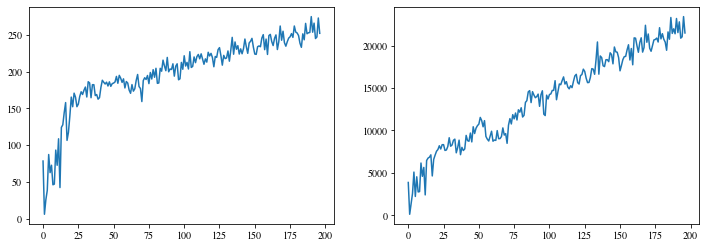

In [282]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(LOL_LONG_ADAPT2.ESS_SMC[1:])
ax[1].plot(LOL_LONG_ADAPT2.ESS[1:])
plt.show()

# Studying Adaptation

Start by only adapting $B$ and not adapting $\delta$. Let's see what happens.

In [471]:
# adapt δ based on EJSD, but keep B fixed (use prop_esjd=0.99)
ONLY_AB_99 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.99))
ONLY_AB_PARTICLES_99 = ONLY_AB_99.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Number of steps adapted to: 90
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8601940227620162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9840000000000000
	Particle Diversity: 0.3660000000000000
	Moved Diversity: 0.3601440000000000
	Number of steps adapted to: 88
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 30.4104668925876851
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop 

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9140000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.3911920000000000
	Number of steps adapted to: 32
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.2649937852662685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9100000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3712800000000000
	Number of steps adapted to: 31
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.8641420449982258
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8780000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.3599800000000000
	Number of steps adapted to: 28
Iteration:  27
	Quantile Value:  0.5
	Tr

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6840000000000001
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.2790720000000000
	Number of steps adapted to: 9
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2877714978414199
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6660000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.2757240000000000
	Number of steps adapted to: 8
Iteration:  50
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2243189900674363
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6660000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.2797200000000000
	Number of steps adapted to: 8
Iteration:  51
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2380000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.1004360000000000
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5792892483027599
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3300000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.1333200000000000
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5710349741385419
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2680000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1125600000000000
	Number of steps adapted to: 5
Iteration:  75
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1120000000000000
	Particle Diversity: 0.2760000000000000
	Moved Diversity: 0.0309120000000000
	Number of steps adapted to: 5
Iteration:  97
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3302337435462028
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0560000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0257600000000000
	Number of steps adapted to: 5
Iteration:  98
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3260268402716788
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0760000000000000
	Particle Diversity: 0.4900000000000000
	Moved Diversity: 0.0372400000000000
	Number of steps adapted to: 5
Iteration:  99
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0120000000000000
	Particle Diversity: 0.6060000000000000
	Moved Diversity: 0.0072720000000000
	Number of steps adapted to: 5
Iteration:  121
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2451856249560436
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0180000000000000
	Particle Diversity: 0.6160000000000000
	Moved Diversity: 0.0110880000000000
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2405476944981739
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Particle Diversity: 0.0140000000000000
	Moved Diversity: 0.0000000000000000
	Number of steps adapted to: 5


In [340]:
# adapt δ based on EJSD, but keep B fixed
ONLY_AB_95 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
ONLY_AB_PARTICLES_95 = ONLY_AB_95.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Number of steps adapted to: 75
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8601940227620162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9680000000000000
	Particle Diversity: 0.3800000000000000
	Moved Diversity: 0.3678400000000000
	Number of steps adapted to: 71
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 30.8388937902629685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop 

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8920000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3621520000000000
	Number of steps adapted to: 24
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.6634677624821723
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8520000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.3373920000000000
	Number of steps adapted to: 23
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.4090771111564564
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8500000000000000
	Particle Diversity: 0.3820000000000000
	Moved Diversity: 0.3247000000000000
	Number of steps adapted to: 23
Iteration:  27
	Quantile Value:  0.5
	Tr

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6240000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.2670720000000000
	Number of steps adapted to: 6
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1184449902456222
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6580000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.2776760000000000
	Number of steps adapted to: 6
Iteration:  50
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0686056415421645
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5720000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.2528240000000000
	Number of steps adapted to: 6
Iteration:  51
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3300000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.1366200000000000
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6097489229394339
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2660000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1058680000000000
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6013996164471886
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2720000000000000
	Particle Diversity: 0.4540000000000000
	Moved Diversity: 0.1234880000000000
	Number of steps adapted to: 5
Iteration:  75
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.4420000000000000
	Moved Diversity: 0.0963560000000000
	Number of steps adapted to: 5
Iteration:  97
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4373386244767490
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1940000000000000
	Particle Diversity: 0.4720000000000000
	Moved Diversity: 0.0915680000000000
	Number of steps adapted to: 5
Iteration:  98
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4321358861001683
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2600000000000000
	Particle Diversity: 0.3480000000000000
	Moved Diversity: 0.0904800000000000
	Number of steps adapted to: 5
Iteration:  99
	Quantile Value:  0.5
	Traje

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1600000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.0694400000000000
	Number of steps adapted to: 5
Iteration:  121
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2332075523398043
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1660000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.0654040000000000
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2264252925413686
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0900000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.0414000000000000
	Number of steps adapted to: 5
Iteration:  123
	Quantile Value:  0.5
	Tr

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0460000000000000
	Particle Diversity: 0.1100000000000000
	Moved Diversity: 0.0050600000000000
	Number of steps adapted to: 5
Iteration:  145
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1489597730706733
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0220000000000000
	Particle Diversity: 0.1120000000000000
	Moved Diversity: 0.0024640000000000
	Number of steps adapted to: 5
Iteration:  146
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1481677162642625
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0220000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.0089320000000000
	Number of steps adapted to: 5
Iteration:  147
	Quantile Value:  0.5
	Tr

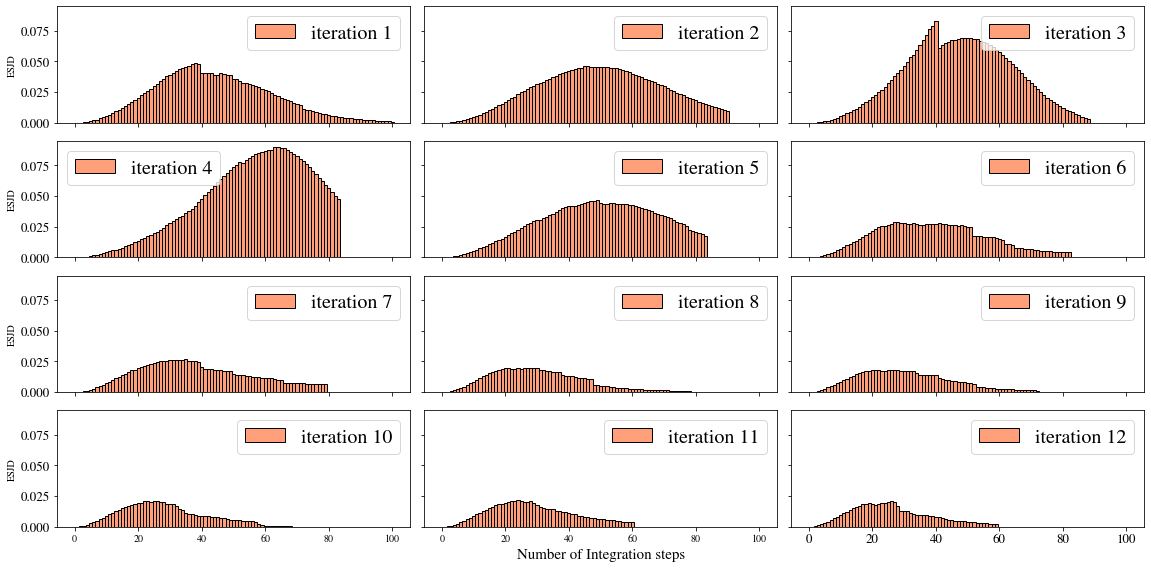

In [852]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].bar(np.arange(ONLY_AB_99.Bs[INDEX1-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX1], width=1.0, edgecolor='k', color='lightsalmon', label="iteration 1")
ax[0, 0].legend(fontsize=20)
ax[0, 0].yaxis.set_tick_params(labelsize=13) 
ax[0, 0].set_ylabel("ESJD")

ax[0, 1].bar(np.arange(ONLY_AB_99.Bs[INDEX2-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX2], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 2')
ax[0, 1].legend(fontsize=20)

ax[0, 2].bar(np.arange(ONLY_AB_99.Bs[INDEX3-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX3], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 3')
ax[0, 2].legend(fontsize=20)
ax[0, 2].xaxis.set_tick_params(labelsize=13) 

ax[1, 0].bar(np.arange(ONLY_AB_99.Bs[INDEX4-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX4], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 4')
ax[1, 0].legend(fontsize=20)
ax[1, 0].yaxis.set_tick_params(labelsize=13) 
ax[1, 0].set_ylabel("ESJD")

ax[1, 1].bar(np.arange(ONLY_AB_99.Bs[INDEX5-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX5], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 5')
ax[1, 1].legend(fontsize=20)

ax[1, 2].bar(np.arange(ONLY_AB_99.Bs[INDEX6-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX6], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 6')
ax[1, 2].legend(fontsize=20)
ax[1, 2].xaxis.set_tick_params(labelsize=13) 

ax[2, 0].bar(np.arange(ONLY_AB_99.Bs[INDEX7-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX7], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 7')
ax[2, 0].legend(fontsize=20)
ax[2, 0].yaxis.set_tick_params(labelsize=13) 
ax[2, 0].set_ylabel("ESJD")

ax[2, 1].bar(np.arange(ONLY_AB_99.Bs[INDEX8-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX8], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 8')
ax[2, 1].legend(fontsize=20)

ax[2, 2].bar(np.arange(ONLY_AB_99.Bs[INDEX9-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX9], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 9')
ax[2, 2].legend(fontsize=20)
ax[2, 2].xaxis.set_tick_params(labelsize=13) 

ax[3, 0].bar(np.arange(ONLY_AB_99.Bs[INDEX10-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX10], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 10')
ax[3, 0].legend(fontsize=20)
ax[3, 0].yaxis.set_tick_params(labelsize=13) 
ax[3, 0].set_ylabel("ESJD")

ax[3, 1].bar(np.arange(ONLY_AB_99.Bs[INDEX11-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX11], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 11')
ax[3, 1].legend(fontsize=20)
ax[3, 1].set_xlabel("Number of Integration steps", fontsize=15)

ax[3, 2].bar(np.arange(ONLY_AB_99.Bs[INDEX12-1]+1), ONLY_AB_99.ESJD_CHANG[INDEX12], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 12')
ax[3, 2].legend(fontsize=20)
ax[3, 2].xaxis.set_tick_params(labelsize=13) 

plt.tight_layout()
plt.savefig("figures/gk20_histograms_esjdchang_first12iter_99.png")
plt.show()

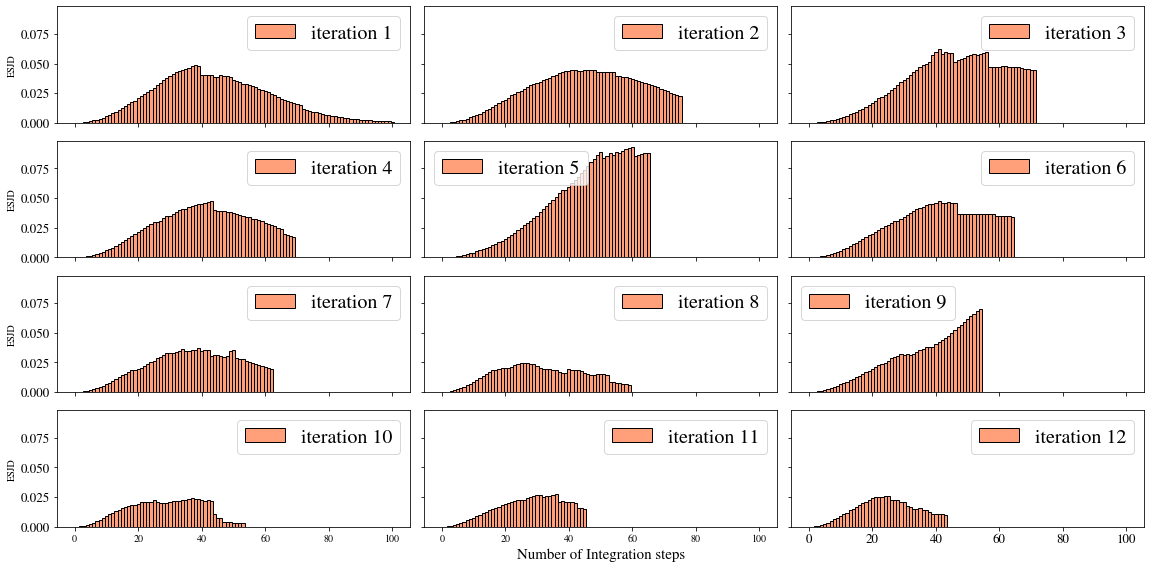

In [342]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX1-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX1], width=1.0, edgecolor='k', color='lightsalmon', label="iteration 1")
ax[0, 0].legend(fontsize=20)
ax[0, 0].yaxis.set_tick_params(labelsize=13) 
ax[0, 0].set_ylabel("ESJD")

ax[0, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX2-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX2], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 2')
ax[0, 1].legend(fontsize=20)

ax[0, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX3-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX3], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 3')
ax[0, 2].legend(fontsize=20)
ax[0, 2].xaxis.set_tick_params(labelsize=13) 

ax[1, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX4-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX4], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 4')
ax[1, 0].legend(fontsize=20)
ax[1, 0].yaxis.set_tick_params(labelsize=13) 
ax[1, 0].set_ylabel("ESJD")

ax[1, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX5-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX5], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 5')
ax[1, 1].legend(fontsize=20)

ax[1, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX6-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX6], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 6')
ax[1, 2].legend(fontsize=20)
ax[1, 2].xaxis.set_tick_params(labelsize=13) 

ax[2, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX7-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX7], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 7')
ax[2, 0].legend(fontsize=20)
ax[2, 0].yaxis.set_tick_params(labelsize=13) 
ax[2, 0].set_ylabel("ESJD")

ax[2, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX8-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX8], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 8')
ax[2, 1].legend(fontsize=20)

ax[2, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX9-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX9], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 9')
ax[2, 2].legend(fontsize=20)
ax[2, 2].xaxis.set_tick_params(labelsize=13) 

ax[3, 0].bar(np.arange(ONLY_AB_95.Bs[INDEX10-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX10], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 10')
ax[3, 0].legend(fontsize=20)
ax[3, 0].yaxis.set_tick_params(labelsize=13) 
ax[3, 0].set_ylabel("ESJD")

ax[3, 1].bar(np.arange(ONLY_AB_95.Bs[INDEX11-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX11], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 11')
ax[3, 1].legend(fontsize=20)
ax[3, 1].set_xlabel("Number of Integration steps", fontsize=15)

ax[3, 2].bar(np.arange(ONLY_AB_95.Bs[INDEX12-1]+1), ONLY_AB_95.ESJD_CHANG[INDEX12], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 12')
ax[3, 2].legend(fontsize=20)
ax[3, 2].xaxis.set_tick_params(labelsize=13) 

plt.tight_layout()
plt.show()

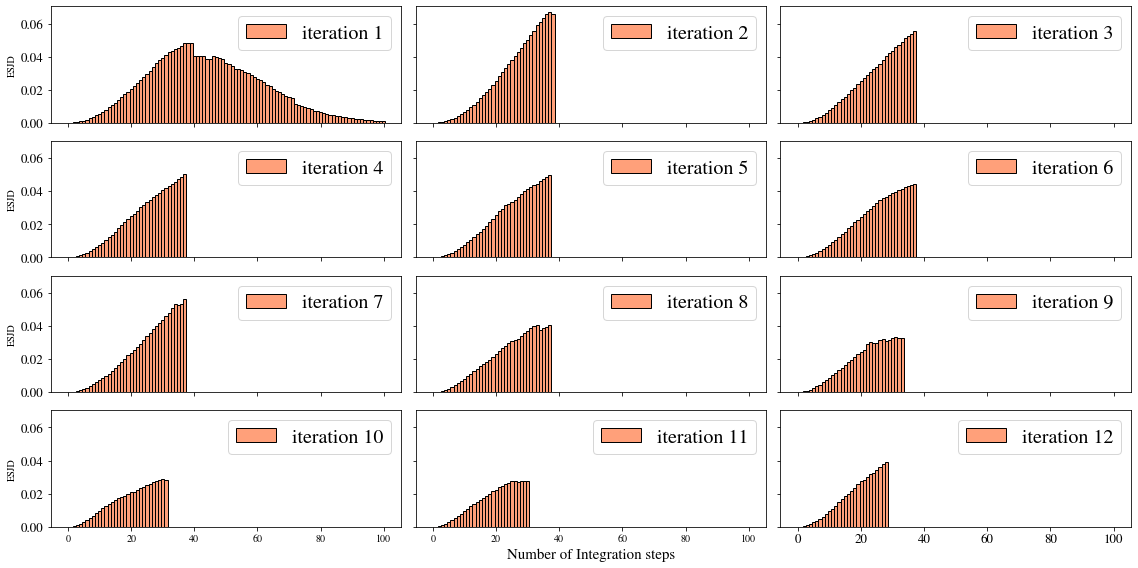

In [853]:
rc('font',**{'family':'STIXGeneral'})
INDEX1 = 1
INDEX2 = 2
INDEX3 = 3
INDEX4 = 4
INDEX5 = 5
INDEX6 = 6
INDEX7 = 7
INDEX8 = 8
INDEX9 = 9
INDEX10 = 10
INDEX11 = 11
INDEX12 = 12
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].bar(np.arange(AB_AN_MAX.Bs[INDEX1-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX1], width=1.0, edgecolor='k', color='lightsalmon', label="iteration 1")
ax[0, 0].legend(fontsize=20)
ax[0, 0].yaxis.set_tick_params(labelsize=13) 
ax[0, 0].set_ylabel("ESJD")

ax[0, 1].bar(np.arange(AB_AN_MAX.Bs[INDEX2-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX2], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 2')
ax[0, 1].legend(fontsize=20)

ax[0, 2].bar(np.arange(AB_AN_MAX.Bs[INDEX3-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX3], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 3')
ax[0, 2].legend(fontsize=20)
ax[0, 2].xaxis.set_tick_params(labelsize=13) 

ax[1, 0].bar(np.arange(AB_AN_MAX.Bs[INDEX4-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX4], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 4')
ax[1, 0].legend(fontsize=20)
ax[1, 0].yaxis.set_tick_params(labelsize=13) 
ax[1, 0].set_ylabel("ESJD")

ax[1, 1].bar(np.arange(AB_AN_MAX.Bs[INDEX5-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX5], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 5')
ax[1, 1].legend(fontsize=20)

ax[1, 2].bar(np.arange(AB_AN_MAX.Bs[INDEX6-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX6], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 6')
ax[1, 2].legend(fontsize=20)
ax[1, 2].xaxis.set_tick_params(labelsize=13) 

ax[2, 0].bar(np.arange(AB_AN_MAX.Bs[INDEX7-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX7], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 7')
ax[2, 0].legend(fontsize=20)
ax[2, 0].yaxis.set_tick_params(labelsize=13) 
ax[2, 0].set_ylabel("ESJD")

ax[2, 1].bar(np.arange(AB_AN_MAX.Bs[INDEX8-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX8], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 8')
ax[2, 1].legend(fontsize=20)

ax[2, 2].bar(np.arange(AB_AN_MAX.Bs[INDEX9-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX9], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 9')
ax[2, 2].legend(fontsize=20)
ax[2, 2].xaxis.set_tick_params(labelsize=13) 

ax[3, 0].bar(np.arange(AB_AN_MAX.Bs[INDEX10-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX10], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 10')
ax[3, 0].legend(fontsize=20)
ax[3, 0].yaxis.set_tick_params(labelsize=13) 
ax[3, 0].set_ylabel("ESJD")

ax[3, 1].bar(np.arange(AB_AN_MAX.Bs[INDEX11-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX11], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 11')
ax[3, 1].legend(fontsize=20)
ax[3, 1].set_xlabel("Number of Integration steps", fontsize=15)

ax[3, 2].bar(np.arange(AB_AN_MAX.Bs[INDEX12-1]+1), AB_AN_MAX.ESJD_CHANG[INDEX12], width=1.0, edgecolor='k', color='lightsalmon', label='iteration 12')
ax[3, 2].legend(fontsize=20)
ax[3, 2].xaxis.set_tick_params(labelsize=13) 

plt.tight_layout()
plt.savefig("figures/gk20_histograms_esjdchang_first12iter_argmax.png")
plt.show()

Compare the two in some way

In [345]:
# KEEP IT FIXED
KEEP_B_FIXED = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[0], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
KEEP_B_FIXED_PARTICLES = KEEP_B_FIXED.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8601940227620162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9780000000000000
	Particle Diversity: 0.3140000000000000
	Moved Diversity: 0.3070920000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 31.0990122564994778
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9140000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.3893640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.4433403691422875
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9100000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3712800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.1492030270587410
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9180000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.4020840000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7360000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.3179520000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8484153256832867
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7240000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.3084240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8090317939044454
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7180000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.3144840000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4940000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2143960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0304320885572014
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5220000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2223720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.0106523989603966
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5320000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.2394000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4260000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.1738080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7126715612283421
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4980000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2001960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6977112602899458
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4440000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1767120000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4340000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.1935640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1603166484482634
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4640000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.2004480000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1373723253747532
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4060000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.1729560000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2940000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.1187760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8007725127870061
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2460000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1033200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7886422441713374
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2340000000000000
	Particle Diversity: 0.4900000000000000
	Moved Diversity: 0.1146600000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0760000000000000
	Particle Diversity: 0.3200000000000000
	Moved Diversity: 0.0243200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6231790300473483
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0700000000000000
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.0305200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  164
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6168158170906818
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0580000000000000
	Particle Diversity: 0.5860000000000000
	Moved Diversity: 0.0339880000000000
	Step-size kept fixed at: 0.0100000000000000

In [354]:
# KEEP IT FIXED
KEEP_B_FIXED20 = MSAdaptive(generate_settings(d=d, N=N, B=20,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[0], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
KEEP_B_FIXED20_PARTICLES = KEEP_B_FIXED20.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9560000000000000
	Particle Diversity: 0.3900000000000000
	Moved Diversity: 0.3728400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 39.1560168312226509
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9480000000000000
	Particle Diversity: 0.4300000000000000
	Moved Diversity: 0.4076399999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 30.0868814736943975
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8820000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.3598560000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5992729139147013
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8580000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.3397680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.2413115843731690
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8820000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.3633840000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5360000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2358400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3958203297600802
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5060000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.2216280000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3540495435607833
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4880000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.2078880000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2960000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.1278720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7386143420812228
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3800000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.1580800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7099915029490647
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5000000000000000
	Particle Diversity: 0.4040000000000000
	Moved Diversity: 0.2020000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2460000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.0969240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1230839089911875
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1920000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.0833280000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1058891524151031
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2060000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.0865200000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1920000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.0810240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7709596447649345
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1820000000000000
	Particle Diversity: 0.3960000000000000
	Moved Diversity: 0.0720720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7538432813133267
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2180000000000000
	Particle Diversity: 0.3680000000000000
	Moved Diversity: 0.0802240000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1200000000000000
	Particle Diversity: 0.1580000000000000
	Moved Diversity: 0.0189600000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4506030564731187
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0340000000000000
	Particle Diversity: 0.4880000000000000
	Moved Diversity: 0.0165920000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4396008745245447
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1320000000000000
	Particle Diversity: 0.1020000000000000
	Moved Diversity: 0.0134640000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Particle Diversity: 0.0020000000000000
	Moved Diversity: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000


In [356]:
# KEEP IT FIXED
KEEP_B_FIXED5 = MSAdaptive(generate_settings(d=d, N=N, B=5,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[0], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
KEEP_B_FIXED5_PARTICLES = KEEP_B_FIXED5.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.3820000000000000
	Moved Diversity: 0.3178240000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 38.1275523815565975
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8360000000000000
	Particle Diversity: 0.4320000000000000
	Moved Diversity: 0.3611520000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 29.5091517218362824
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7980000000000000
	Particle Diversity: 0.4840000000000000
	Moved Diversity: 0.3862320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 10.1640288578019593
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8320000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.3710720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.8576051152688766
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8300000000000000
	Particle Diversity: 0.4680000000000000
	Moved Diversity: 0.3884400000000000
	Step-size kept fixed at: 0.0100000000000000


	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7160000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.3222000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.6867263970415163
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7280000000000000
	Particle Diversity: 0.4560000000000000
	Moved Diversity: 0.3319680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.5905259819188906
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7080000000000000
	Particle Diversity: 0.4080000000000000
	Moved Diversity: 0.2888640000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6400000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.2700800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7257244137430030
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6320000000000000
	Particle Diversity: 0.4020000000000000
	Moved Diversity: 0.2540640000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6525906104921182
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5679999999999999
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2499200000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4480000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1783040000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8686034834528229
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4540000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.1788760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8308514151008786
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4560000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.1851360000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3340000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.1503000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3951665151818187
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3660000000000000
	Particle Diversity: 0.3880000000000000
	Moved Diversity: 0.1420080000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3747069042693889
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3140000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.1249720000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3300000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.1405800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8264517781263341
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3380000000000000
	Particle Diversity: 0.4140000000000000
	Moved Diversity: 0.1399320000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8075279342682302
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3120000000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.1285440000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1480000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.0615680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4011562821204566
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.0770800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3892086957693925
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1620000000000000
	Particle Diversity: 0.4640000000000000
	Moved Diversity: 0.0751680000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2540000000000000
	Particle Diversity: 0.1440000000000000
	Moved Diversity: 0.0365760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1606775234989319
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1260000000000000
	Particle Diversity: 0.4260000000000000
	Moved Diversity: 0.0536760000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1495351992250324
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1420000000000000
	Particle Diversity: 0.3760000000000000
	Moved Diversity: 0.0533920000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0260000000000000
	Particle Diversity: 0.4980000000000000
	Moved Diversity: 0.0129480000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8838729335913350
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0520000000000000
	Particle Diversity: 0.3100000000000000
	Moved Diversity: 0.0161200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8791194501754998
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1080000000000000
	Particle Diversity: 0.1280000000000000
	Moved Diversity: 0.0138240000000000
	Step-size kept fixed at: 0.0100000000000000

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1660000000000000
	Particle Diversity: 0.0960000000000000
	Moved Diversity: 0.0159360000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7086375239545583
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0320000000000000
	Particle Diversity: 0.4700000000000000
	Moved Diversity: 0.0150400000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7037585844521961
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0280000000000000
	Particle Diversity: 0.5180000000000000
	Moved Diversity: 0.0145040000000000
	Step-size kept fixed at: 0.0100000000000000

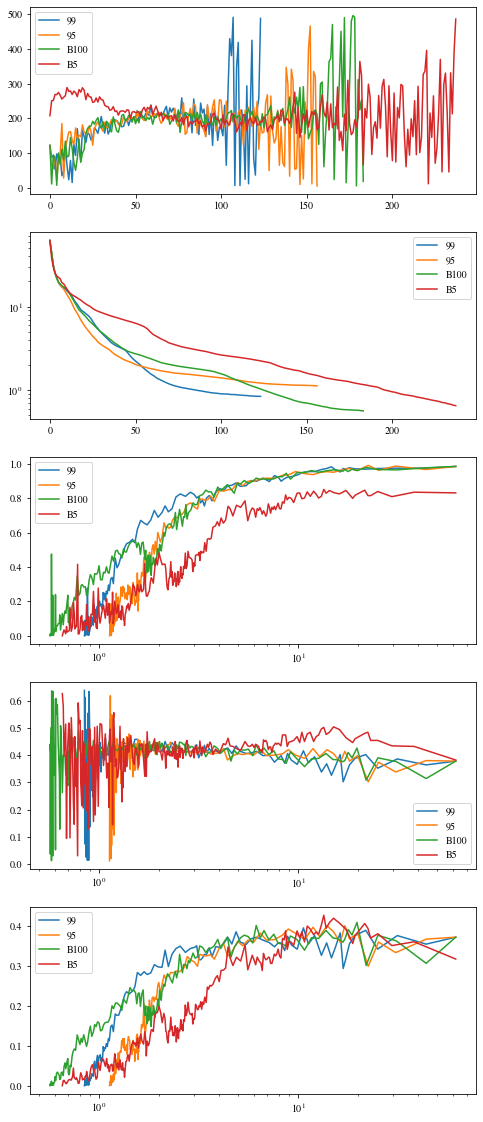

In [376]:
nrows=5
fig, ax = plt.subplots(nrows=nrows, figsize=(8, 4*nrows))
# ESS-SMC
ax[0].plot(ONLY_AB_99.ESS_SMC[1:], label='99')
ax[0].plot(ONLY_AB_95.ESS_SMC[1:], label='95')
ax[0].plot(KEEP_B_FIXED.ESS_SMC[1:], label='B100')
ax[0].plot(KEEP_B_FIXED5.ESS_SMC[1:], label='B5')
ax[0].legend()
# EPSILONS
ax[1].plot(ONLY_AB_99.εs[1:], label='99')
ax[1].plot(ONLY_AB_95.εs[1:], label='95')
ax[1].plot(KEEP_B_FIXED.εs[1:], label='B100')
ax[1].plot(KEEP_B_FIXED5.εs[1:], label='B5')
ax[1].set_yscale('log')
ax[1].legend()
# PROPORTION OF PARTICLES MOVED OVER EPSILON
ax[2].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.PROP_MOVED[1:], label='99')
ax[2].plot(ONLY_AB_95.εs[1:], ONLY_AB_95.PROP_MOVED[1:], label='95')
ax[2].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.PROP_MOVED[1:], label='B100')
ax[2].plot(KEEP_B_FIXED5.εs[1:], KEEP_B_FIXED5.PROP_MOVED[1:], label='B5')
ax[2].set_xscale('log')
ax[2].legend()
# PARTICLE DIVERSITY
ax[3].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.P_DIVERSITY[1:], label='99')
ax[3].plot(ONLY_AB_95.εs[1:], ONLY_AB_95.P_DIVERSITY[1:], label='95')
ax[3].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.P_DIVERSITY[1:], label='B100')
ax[3].plot(KEEP_B_FIXED5.εs[1:], KEEP_B_FIXED5.P_DIVERSITY[1:], label='B5')
ax[3].set_xscale('log')
ax[3].legend()
# DIVERSITY MOVED
ax[4].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.DIV_MOVED[1:], label='99')
ax[4].plot(ONLY_AB_95.εs[1:], ONLY_AB_95.DIV_MOVED[1:], label='95')
ax[4].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.DIV_MOVED[1:], label='B100')
ax[4].plot(KEEP_B_FIXED5.εs[1:], KEEP_B_FIXED5.DIV_MOVED[1:], label='B5')
ax[4].set_xscale('log')
ax[4].legend()
plt.legend()
plt.show()

Seems that small $B$ is fundamental.

# Relationship between $B$ and $N$

We fix the computational budget per iteration to $50000$ and compare two scenarios:

1. **Large $N$, small $B$**: $N=500$ and $B=100$
2. **Small $N$, large $B$**: $N=10\,000$ and $B=5$

In [375]:
# KEEP IT FIXED, LARGE B, SMALL N
B5N10k = MSAdaptive(generate_settings(d=d, N=10000, B=5,
        δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN10k.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B5N10k_PARTICLES = B5N10k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.0069753305084248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8361000000000000
	Particle Diversity: 0.4485000000000000
	Moved Diversity: 0.3749908500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.5073596183209617
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8405000000000000
	Particle Diversity: 0.4377000000000000
	Moved Diversity: 0.3678868500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.9543887303735161
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8220000000000000
	Particle Diversity: 0.4614000000000000
	Moved Diversity: 0.3792708000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.6087987526476581
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8169000000000000
	Particle Diversity: 0.4677000000000000
	Moved Diversity: 0.3820641300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.1875258183879254
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8182000000000000
	Particle Diversity: 0.4755000000000000
	Moved Diversity: 0.3890541000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Epsilon: 3.3049217652082468
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6871000000000000
	Particle Diversity: 0.4282000000000000
	Moved Diversity: 0.2942162200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2219991944178781
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6814000000000000
	Particle Diversity: 0.4256000000000000
	Moved Diversity: 0.2900038400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1391520810072193
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6701000000000000
	Particle Diversity: 0.4326000000000000
	Moved Diversity: 0.2898852600000000
	Step-size kept f

	Epsilon: 1.7314372916220626
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5337000000000000
	Particle Diversity: 0.4219000000000000
	Moved Diversity: 0.2251680300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6878128780868191
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5159000000000000
	Particle Diversity: 0.4214000000000000
	Moved Diversity: 0.2174002600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6476027064928105
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4986000000000000
	Particle Diversity: 0.4293000000000000
	Moved Diversity: 0.2140489800000000
	Step-size kept f

	Epsilon: 1.1650058859644803
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4060000000000000
	Particle Diversity: 0.4173000000000000
	Moved Diversity: 0.1694238000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1261855196805031
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3839000000000000
	Particle Diversity: 0.4306000000000000
	Moved Diversity: 0.1653073400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0907503190963490
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3376000000000000
	Particle Diversity: 0.4449000000000000
	Moved Diversity: 0.1501982400000000
	Step-size kept f

	Epsilon: 0.6887058194643493
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1132000000000000
	Particle Diversity: 0.3886000000000000
	Moved Diversity: 0.0439895200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6766647872708185
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1145000000000000
	Particle Diversity: 0.3674000000000000
	Moved Diversity: 0.0420673000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6635482146227905
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0965000000000000
	Particle Diversity: 0.4162000000000000
	Moved Diversity: 0.0401633000000000
	Step-size kept

	Epsilon: 0.4598456592258399
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0240000000000000
	Particle Diversity: 0.3398000000000000
	Moved Diversity: 0.0081552000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4535705284910393
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0159000000000000
	Particle Diversity: 0.2248000000000000
	Moved Diversity: 0.0035743200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4484137499697994
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0128000000000000
	Particle Diversity: 0.3309000000000000
	Moved Diversity: 0.0042355200000000
	Step-size kept

	Epsilon: 0.3646092279259172
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0025000000000000
	Particle Diversity: 0.4460000000000000
	Moved Diversity: 0.0011150000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3586607704561044
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0077000000000000
	Particle Diversity: 0.2072000000000000
	Moved Diversity: 0.0015954400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3524024011839417
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0021000000000000
	Particle Diversity: 0.3027000000000000
	Moved Diversity: 0.0006356700000000
	Step-size kept

	Epsilon: 0.2444058209011026
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0004000000000000
	Particle Diversity: 0.5480000000000000
	Moved Diversity: 0.0002192000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2433817933397504
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Particle Diversity: 0.0010000000000000
	Moved Diversity: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000


Now compare the two

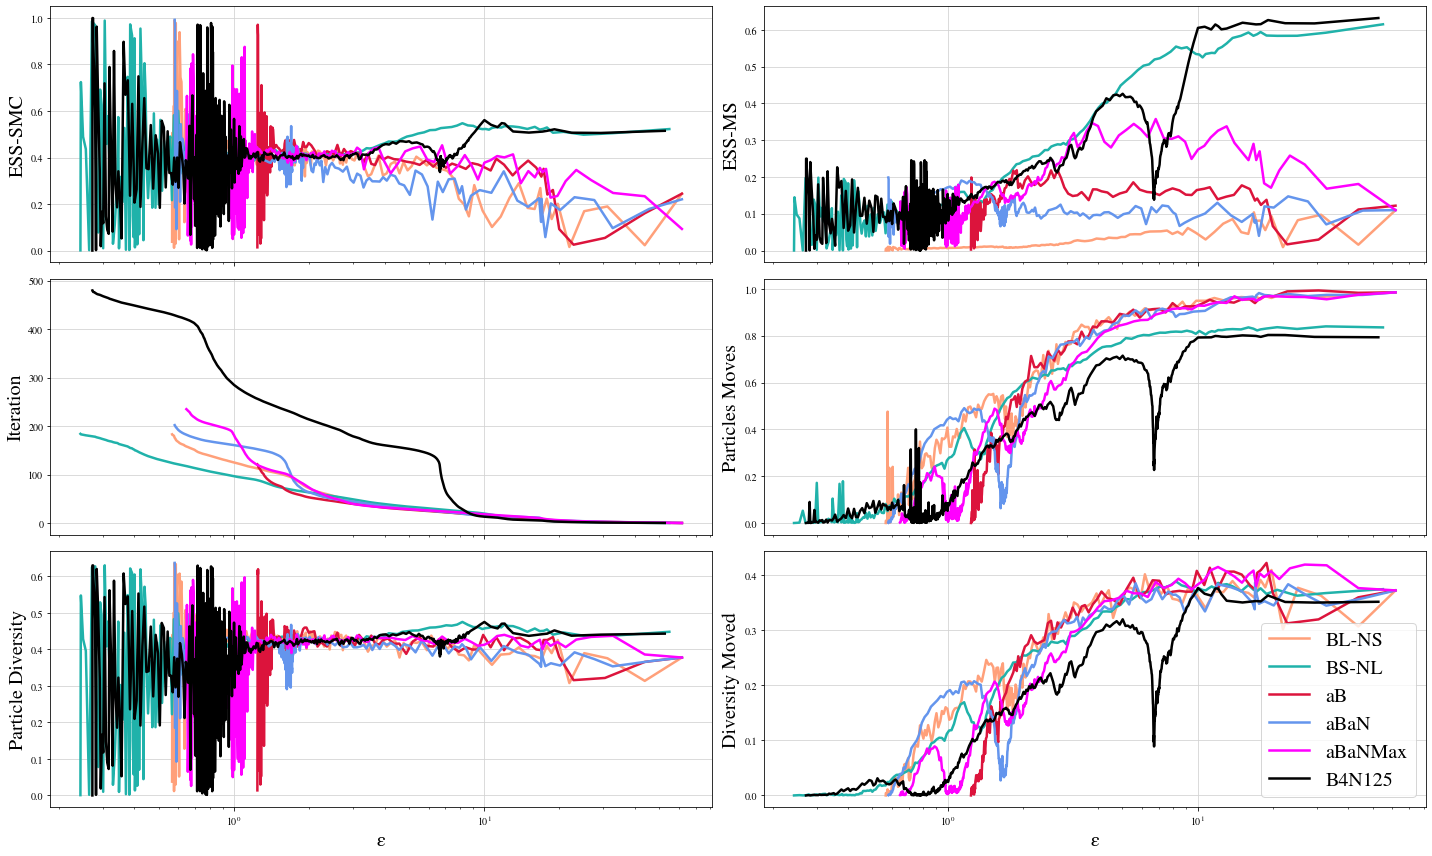

In [548]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 12), sharex=True)
FS=20
LFS=20
LW = 2.5
C1 = "lightsalmon"
C2 = "lightseagreen"
C3 = "crimson"
C4 = "cornflowerblue"
C5 = "fuchsia"
C6 = 'black'
# ESS-SMC
ax[0, 0].plot(KEEP_B_FIXED.εs[1:], np.array(KEEP_B_FIXED.ESS_SMC[1:])/KEEP_B_FIXED.N, label='BL-NS', lw=LW, color=C1) #N=500, B=100
ax[0, 0].plot(B5N10k.εs[1:], np.array(B5N10k.ESS_SMC[1:])/B5N10k.N, label='BS-NL', lw=LW, color=C2)       #N=10000, B=5
ax[0, 0].plot(ONLY_AB_99.εs[1:], np.array(ONLY_AB_99.ESS_SMC[1:])/ONLY_AB_99.N, label='aB', lw=LW, color=C3)
ax[0, 0].plot(AB_AN_99.εs[1:], np.array(AB_AN_99.ESS_SMC[1:])/np.array(AB_AN_99.Ns[1:]), label='aBaN', lw=LW, color=C4)
ax[0, 0].plot(AB_AN_MAX.εs[1:], np.array(AB_AN_MAX.ESS_SMC[1:])/np.array(AB_AN_MAX.Ns[1:]), label='aBaNMax', lw=LW, color=C5)
ax[0, 0].plot(B4N12500.εs[1:], np.array(B4N12500.ESS_SMC[1:])/B4N12500.N, label='B4N125', lw=LW, color=C6)
ax[0, 0].set_xscale('log')
# ax[0, 0].legend(fontsize=LFS) 
ax[0, 0].set_ylabel("ESS-SMC", fontsize=FS)
# ESS-MS
ax[0, 1].plot(KEEP_B_FIXED.εs[1:], np.array(KEEP_B_FIXED.ESS[1:])/50000, label='BL-NS', lw=LW, color=C1) #N=500, B=100
ax[0, 1].plot(B5N10k.εs[1:], np.array(B5N10k.ESS[1:])/50000, label='BS-NL', lw=LW, color=C2)       #N=10000, B=5
ax[0, 1].plot(ONLY_AB_99.εs[1:], np.array(ONLY_AB_99.ESS[1:]) / (np.array(ONLY_AB_99.Bs[1:])*ONLY_AB_99.N), label='aB', lw=LW, color=C3)
ax[0, 1].plot(AB_AN_99.εs[1:], np.array(AB_AN_99.ESS[1:]) / (np.array(AB_AN_99.Bs[1:])*AB_AN_99.Ns[1:]), label='aBaN', lw=LW, color=C4)
ax[0, 1].plot(AB_AN_MAX.εs[1:], np.array(AB_AN_MAX.ESS[1:]) / (np.array(AB_AN_MAX.Bs[1:])*AB_AN_MAX.Ns[1:]), label='aBaNMax', lw=LW, color=C5)
ax[0, 1].plot(B4N12500.εs[1:], np.array(B4N12500.ESS[1:])/50000, label='B4N125', lw=LW, color=C6)       #N=10000, B=5
ax[0, 1].set_xscale('log')
# ax[0, 1].legend(fontsize=LFS) 
ax[0, 1].set_ylabel("ESS-MS", fontsize=FS)
# EPSILONS
ax[1, 0].plot(KEEP_B_FIXED.εs[1:], np.arange(len(KEEP_B_FIXED.εs[1:])), label='BL-NS', lw=LW, color=C1)
ax[1, 0].plot(B5N10k.εs[1:], np.arange(len(B5N10k.εs[1:])), label='BS-NL', lw=LW, color=C2)
ax[1, 0].plot(ONLY_AB_99.εs[1:], np.arange(len(ONLY_AB_99.εs[1:])), label='aB', lw=LW, color=C3)
ax[1, 0].plot(AB_AN_99.εs[1:], np.arange(len(AB_AN_99.εs[1:])), label='aBaN', lw=LW, color=C4)
ax[1, 0].plot(AB_AN_MAX.εs[1:], np.arange(len(AB_AN_MAX.εs[1:])), label='aBaNMax', lw=LW, color=C5)
ax[1, 0].plot(B4N12500.εs[1:], np.arange(len(B4N12500.εs[1:])), label='B4N125', lw=LW, color=C6)
ax[1, 0].set_xscale('log')
# ax[1, 0].legend(fontsize=LFS)
ax[1, 0].set_ylabel("Iteration", fontsize=FS)
# PROPORTION OF PARTICLES MOVED OVER EPSILON
ax[1, 1].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.PROP_MOVED[1:], label='BL-NS', lw=LW, color=C1)
ax[1, 1].plot(B5N10k.εs[1:], B5N10k.PROP_MOVED[1:], label='BS-NL', lw=LW, color=C2)
ax[1, 1].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.PROP_MOVED[1:], label='aB', lw=LW, color=C3)
ax[1, 1].plot(AB_AN_99.εs[1:], AB_AN_99.PROP_MOVED[1:], label='aBaN', lw=LW, color=C4)
ax[1, 1].plot(AB_AN_MAX.εs[1:], AB_AN_MAX.PROP_MOVED[1:], label='aBaNMax', lw=LW, color=C5)
ax[1, 1].plot(B4N12500.εs[1:], B4N12500.PROP_MOVED[1:], label='B4N125', lw=LW, color=C6)
ax[1, 1].set_xscale('log')
# ax[1, 1].legend(fontsize=LFS)
ax[1, 1].set_ylabel("Particles Moves", fontsize=FS)
# PARTICLE DIVERSITY
ax[2, 0].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.P_DIVERSITY[1:], label='BL-NS', lw=LW, color=C1)
ax[2, 0].plot(B5N10k.εs[1:], B5N10k.P_DIVERSITY[1:], label='BS-NL', lw=LW, color=C2)
ax[2, 0].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.P_DIVERSITY[1:], label='aB', lw=LW, color=C3)
ax[2, 0].plot(AB_AN_99.εs[1:], AB_AN_99.P_DIVERSITY[1:], label='aBaN', lw=LW, color=C4)
ax[2, 0].plot(AB_AN_MAX.εs[1:], AB_AN_MAX.P_DIVERSITY[1:], label='aBaNMax', lw=LW, color=C5)
ax[2, 0].plot(B4N12500.εs[1:], B4N12500.P_DIVERSITY[1:], label='B4N125', lw=LW, color=C6)
ax[2, 0].set_xscale('log')
# ax[2, 0].legend(fontsize=LFS)
ax[2, 0].set_ylabel("Particle Diversity", fontsize=FS)
ax[2, 0].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=FS)
# DIVERSITY MOVED
ax[2, 1].plot(KEEP_B_FIXED.εs[1:], KEEP_B_FIXED.DIV_MOVED[1:], label='BL-NS', lw=LW, color=C1)
ax[2, 1].plot(B5N10k.εs[1:], B5N10k.DIV_MOVED[1:], label='BS-NL', lw=LW, color=C2)
ax[2, 1].plot(ONLY_AB_99.εs[1:], ONLY_AB_99.DIV_MOVED[1:], label='aB', lw=LW, color=C3)
ax[2, 1].plot(AB_AN_99.εs[1:], AB_AN_99.DIV_MOVED[1:], label='aBaN', lw=LW, color=C4)
ax[2, 1].plot(AB_AN_MAX.εs[1:], AB_AN_MAX.DIV_MOVED[1:], label='aBaNMax', lw=LW, color=C5)
ax[2, 1].plot(B4N12500.εs[1:], B4N12500.DIV_MOVED[1:], label='B4N125', lw=LW, color=C6)
ax[2, 1].set_xscale('log')
# ax[2, 1].legend(fontsize=LFS)
ax[2, 1].set_ylabel("Diversity Moved", fontsize=FS)
ax[2, 1].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=FS)
for i in range(3):
    for j in range(2):
        ax[i, j].grid(True, color='lightgray')
plt.legend(fontsize=LFS)
plt.tight_layout()
# plt.savefig("figures/gk20_relationship_bn_new_max.png")
plt.show()

The key difference is that BL-NS and BS-NL keep the computational budget fixed, whereas 99 doesn't and at the end it basically has 500 particles moving by 5 steps at a time. Instead, I want to do something similar for it.

In [511]:
# adapt δ based on EJSD, but keep B fixed (use prop_esjd=0.99)
AB_AN_99 = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.99, adaptiveN=True, NBbudget=50000))
AB_AN_99_PARTICLES = AB_AN_99.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Number of steps adapted to: 90
	Number of particles adapted to: 555
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 45.6494491086519290
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9747747747747748
	Particle Diversity: 0.3675675675675676
	Moved Diversity: 0.3582955928901875
	Number of steps adapted to: 83
	Number of particles adapted to: 602
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.6534202305037127
	Weights computed and normalized.
	SMC Weights co

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9087363494539782
	Particle Diversity: 0.4079563182527301
	Moved Diversity: 0.3707247353856713
	Number of steps adapted to: 38
	Number of particles adapted to: 1315
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.2179347774208580
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9163498098859315
	Particle Diversity: 0.3893536121673004
	Moved Diversity: 0.3567841084879064
	Number of steps adapted to: 37
	Number of particles adapted to: 1351
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.8375221507783719
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9082161361954109
	Particle Diversity: 0.4152479644707624
	Moved Diversity: 0.3771349018546

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7728000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3137568000000001
	Number of steps adapted to: 20
	Number of particles adapted to: 2500
Iteration:  45
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0083765856619880
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7704000000000000
	Particle Diversity: 0.4060000000000000
	Moved Diversity: 0.3127824000000000
	Number of steps adapted to: 19
	Number of particles adapted to: 2631
Iteration:  46
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.9205446462317468
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7643481565944508
	Particle Diversity: 0.4177118966172558
	Moved Diversity: 0.3192773181669

	Epsilon: 1.9561052945141033
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4952000000000000
	Particle Diversity: 0.4211200000000000
	Moved Diversity: 0.2085386240000000
	Number of steps adapted to: 8
	Number of particles adapted to: 6250
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9347404746304668
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4372800000000000
	Particle Diversity: 0.4329600000000000
	Moved Diversity: 0.1893247488000000
	Number of steps adapted to: 8
	Number of particles adapted to: 6250
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9168736955383210
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4140800000000000
	Particle Diversity: 0.4251200000000000
	Moved

	Epsilon: 1.7340547120458771
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1898000000000000
	Particle Diversity: 0.4179000000000000
	Moved Diversity: 0.0793174200000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  89
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7296150572069027
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1618000000000000
	Particle Diversity: 0.4158000000000000
	Moved Diversity: 0.0672764400000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  90
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7255000204103235
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1390000000000000
	Particle Diversity: 0.4039000000000000
	Mov

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1121000000000000
	Particle Diversity: 0.4242000000000000
	Moved Diversity: 0.0475528200000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  110
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6639772663613706
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1535000000000000
	Particle Diversity: 0.3015000000000000
	Moved Diversity: 0.0462802500000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  111
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6597466195320667
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1499000000000000
	Particle Diversity: 0.4135000000000000
	Moved Diversity: 0.06198365000

	Epsilon: 1.5843581187510603
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2383000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.0938902000000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  132
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5779805596491223
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2428000000000000
	Particle Diversity: 0.3708000000000000
	Moved Diversity: 0.0900302400000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5717117197511656
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2183000000000000
	Particle Diversity: 0.4184000000000000
	M

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4892000000000000
	Particle Diversity: 0.4245000000000000
	Moved Diversity: 0.2076654000000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  153
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2508279722603592
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4738000000000000
	Particle Diversity: 0.4267000000000000
	Moved Diversity: 0.2021704600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  154
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2238458618538171
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4697000000000000
	Particle Diversity: 0.4363000000000000
	Moved Diversity: 0.20493011000

	Epsilon: 0.7277915566045102
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2106000000000000
	Particle Diversity: 0.4261000000000000
	Moved Diversity: 0.0897366600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  175
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7170273892032866
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2062000000000000
	Particle Diversity: 0.4165000000000000
	Moved Diversity: 0.0858823000000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  176
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7066509717482949
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1651000000000000
	Particle Diversity: 0.4407000000000000
	M

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0165000000000000
	Particle Diversity: 0.4329000000000000
	Moved Diversity: 0.0071428500000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  196
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5917903178093953
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0036000000000000
	Particle Diversity: 0.5264000000000000
	Moved Diversity: 0.0018950400000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  197
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5898546521426982
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0044000000000000
	Particle Diversity: 0.2142000000000000
	Moved Diversity: 0.00094248000

Now try with strategy 'median' to adapt B

In [532]:
# adapt δ based on EJSD, but keep B fixed (use prop_esjd=0.99)
AB_AN_MAX = MSAdaptive(generate_settings(d=d, N=N, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/N), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.99, adaptiveN=True, NBbudget=50000, 
        Badaptation_method='argmax'))
AB_AN_MAX_PARTICLES = AB_AN_MAX.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 61.7495926425412449
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9860000000000000
	Particle Diversity: 0.3780000000000000
	Moved Diversity: 0.3727080000000000
	Number of steps adapted to: 38
	Number of particles adapted to: 1315
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 43.8601940227620162
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9756653992395438
	Particle Diversity: 0.3863117870722433
	Moved Diversity: 0.3769110439647819
	Number of steps adapted to: 37
	Number of particles adapted to: 1351
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.7698916250995467
	Weights computed and normalized.
	SMC Weights 

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9173750425025502
	Particle Diversity: 0.4294457667460048
	Moved Diversity: 0.3939628285211564
	Number of steps adapted to: 17
	Number of particles adapted to: 2941
Iteration:  23
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.8733207776851124
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9146548792927576
	Particle Diversity: 0.4185651139068344
	Moved Diversity: 0.3828426237366150
	Number of steps adapted to: 15
	Number of particles adapted to: 3333
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.3204030973329122
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9000900090009001
	Particle Diversity: 0.4188418841884188
	Moved Diversity: 0.3769953953091

	Epsilon: 2.8189674592197260
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5893000000000000
	Particle Diversity: 0.4286000000000000
	Moved Diversity: 0.2525739800000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  45
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7780792275484703
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5873000000000000
	Particle Diversity: 0.4220000000000000
	Moved Diversity: 0.2478406000000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  46
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7401365849444681
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5813000000000000
	Particle Diversity: 0.4244000000000000
	Mov

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4554000000000000
	Particle Diversity: 0.4214000000000000
	Moved Diversity: 0.1919055600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  66
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1417388911094268
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4851000000000000
	Particle Diversity: 0.4186000000000000
	Moved Diversity: 0.2030628600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1177130195547038
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4704000000000000
	Particle Diversity: 0.4167000000000000
	Moved Diversity: 0.1960156800000

	Epsilon: 1.8206218647556194
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3414000000000000
	Particle Diversity: 0.4124000000000000
	Moved Diversity: 0.1407933600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  88
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8069584283647591
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3597000000000000
	Particle Diversity: 0.4206000000000000
	Moved Diversity: 0.1512898200000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  89
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7930166951362028
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3260000000000000
	Particle Diversity: 0.4344000000000000
	Mov

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4336000000000000
	Particle Diversity: 0.4336000000000000
	Moved Diversity: 0.1880089600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  109
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4298350323849431
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4268000000000000
	Particle Diversity: 0.4316000000000000
	Moved Diversity: 0.1842068800000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  110
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4065066600450438
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3906000000000000
	Particle Diversity: 0.4402000000000000
	Moved Diversity: 0.17194212000

	Epsilon: 1.1683985727602320
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1271000000000000
	Particle Diversity: 0.3513000000000000
	Moved Diversity: 0.0446502300000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  131
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1624583697762101
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1093000000000000
	Particle Diversity: 0.3702000000000000
	Moved Diversity: 0.0404628600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  132
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1571703345166879
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0863000000000000
	Particle Diversity: 0.3640000000000000
	M

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0094000000000000
	Particle Diversity: 0.4803000000000000
	Moved Diversity: 0.0045148200000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  152
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0882702228278667
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0606000000000000
	Particle Diversity: 0.0763000000000000
	Moved Diversity: 0.0046237800000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  153
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0858234249034633
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0199000000000000
	Particle Diversity: 0.5175999999999999
	Moved Diversity: 0.01030024000

	Epsilon: 1.0240950759774394
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0469000000000000
	Particle Diversity: 0.2039000000000000
	Moved Diversity: 0.0095629100000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  174
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0208028205102617
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0399000000000000
	Particle Diversity: 0.4144000000000000
	Moved Diversity: 0.0165345600000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  175
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0175513798390297
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0428000000000000
	Particle Diversity: 0.1617000000000000
	M

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1926000000000000
	Particle Diversity: 0.2389000000000000
	Moved Diversity: 0.0460121400000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  195
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9407603957660999
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1944000000000000
	Particle Diversity: 0.3553000000000000
	Moved Diversity: 0.0690703200000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  196
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9283520290498898
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1998000000000000
	Particle Diversity: 0.3197000000000000
	Moved Diversity: 0.06387606000

	Epsilon: 0.7071541770168389
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0437000000000000
	Particle Diversity: 0.2160000000000000
	Moved Diversity: 0.0094392000000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  217
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7031934796237568
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0343000000000000
	Particle Diversity: 0.3295000000000000
	Moved Diversity: 0.0113018500000000
	Number of steps adapted to: 5
	Number of particles adapted to: 10000
Iteration:  218
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6989655630318823
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0177000000000000
	Particle Diversity: 0.4737000000000000
	M

The one above adapts the number $N$. Instead, I could try and keep it fixed and just adapt B and see how it compares to the other algorithms. 

In [816]:
# adapt δ based on EJSD, but keep B fixed (use prop_esjd=0.99)
AB_FN_MAX = MSAdaptive(generate_settings(d=d, N=10000, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.99, adaptiveN=False, NBbudget=None, 
        Badaptation_method='argmax'))
AB_FN_MAX_PARTICLES = AB_FN_MAX.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.0069753305084248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9784000000000000
	Particle Diversity: 0.3567000000000000
	Moved Diversity: 0.3489952800000000
	Number of steps adapted to: 59
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.2208086967043599
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9761000000000000
	Particle Diversity: 0.3561000000000000
	Moved Diversity: 0.3475892100000000
	Number of steps adapted to: 57
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.4985610971332193
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop 

	Epsilon: 3.8887157446088234
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8504000000000000
	Particle Diversity: 0.4317000000000000
	Moved Diversity: 0.3671176800000000
	Number of steps adapted to: 8
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6651479359306376
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8280999999999999
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.3593954000000000
	Number of steps adapted to: 8
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4753329690767130
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8249000000000000
	Particle Diversity: 0.4277000000000000
	Moved Diversity: 0.3528097300000000
	Number of steps adapted to: 8
Iteration:  27

	Epsilon: 1.3476478347548071
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5800000000000000
	Particle Diversity: 0.4342000000000000
	Moved Diversity: 0.2518359999999999
	Number of steps adapted to: 5
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2984615804455122
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5824000000000000
	Particle Diversity: 0.4319000000000000
	Moved Diversity: 0.2515385600000000
	Number of steps adapted to: 5
Iteration:  50
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2515922833648521
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5611000000000000
	Particle Diversity: 0.4362000000000000
	Moved Diversity: 0.2447518200000000
	Number of steps adapted to: 5
Iteration:  51

	Epsilon: 0.6930634675914440
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1783000000000000
	Particle Diversity: 0.4001000000000000
	Moved Diversity: 0.0713378300000000
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6796057347802282
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1417000000000000
	Particle Diversity: 0.4270000000000000
	Moved Diversity: 0.0605059000000000
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6673539558396383
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1438000000000000
	Particle Diversity: 0.3883000000000000
	Moved Diversity: 0.0558375400000000
	Number of steps adapted to: 5
Iteration:  75

	Epsilon: 0.4569414877178865
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0516000000000000
	Particle Diversity: 0.2155000000000000
	Moved Diversity: 0.0111198000000000
	Number of steps adapted to: 5
Iteration:  97
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4496934863897326
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0228000000000000
	Particle Diversity: 0.5213000000000000
	Moved Diversity: 0.0118856400000000
	Number of steps adapted to: 5
Iteration:  98
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4418948287861916
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0478000000000000
	Particle Diversity: 0.2252000000000000
	Moved Diversity: 0.0107645600000000
	Number of steps adapted to: 5
Iteration:  99

	Epsilon: 0.2947106189000130
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0229000000000000
	Particle Diversity: 0.0344000000000000
	Moved Diversity: 0.0007877600000000
	Number of steps adapted to: 5
Iteration:  121
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2904337618981168
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0083000000000000
	Particle Diversity: 0.1095000000000000
	Moved Diversity: 0.0009088500000000
	Number of steps adapted to: 5
Iteration:  122
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2857770806773763
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0059000000000000
	Particle Diversity: 0.2055000000000000
	Moved Diversity: 0.0012124500000000
	Number of steps adapted to: 5
Iteration:  

Let's now do the same but with the other adaptive strategy

In [856]:
# adapt δ based on EJSD, but keep B fixed (use prop_esjd=0.99)
AB_FN_BULK99 = MSAdaptive(generate_settings(d=d, N=10000, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=True,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.99, adaptiveN=False, NBbudget=None, 
        Badaptation_method='prop_cum_esjd'))
AB_FN_BULK99_PARTICLES = AB_FN_BULK99.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.0069753305084248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9784000000000000
	Particle Diversity: 0.3567000000000000
	Moved Diversity: 0.3489952800000000
	Number of steps adapted to: 98
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.2208086967043599
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9787000000000000
	Particle Diversity: 0.3562000000000000
	Moved Diversity: 0.3486129400000000
	Number of steps adapted to: 94
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.3113893157943863
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop 

	Trajectories constructed.
	Epsilon: 4.2100635003909135
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8676000000000000
	Particle Diversity: 0.4094000000000000
	Moved Diversity: 0.3551954400000000
	Number of steps adapted to: 33
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.0144209532260726
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8647000000000000
	Particle Diversity: 0.4149000000000000
	Moved Diversity: 0.3587640300000000
	Number of steps adapted to: 29
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8345214816140545
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8534000000000000
	Particle Diversity: 0.4121000000000000
	Moved Diversity: 0.3516861400000000
	Number of steps

	Epsilon: 1.1884761330009914
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6083000000000000
	Particle Diversity: 0.4332000000000000
	Moved Diversity: 0.2635155600000000
	Number of steps adapted to: 7
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1281526603870033
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5924000000000000
	Particle Diversity: 0.4340000000000000
	Moved Diversity: 0.2571016000000000
	Number of steps adapted to: 7
Iteration:  50
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0680440253825250
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5768000000000000
	Particle Diversity: 0.4355000000000000
	Moved Diversity: 0.2511964000000000
	Number of steps adapted to: 7
Iteration:  51

	Epsilon: 0.3739093172275464
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1503000000000000
	Particle Diversity: 0.4110000000000000
	Moved Diversity: 0.0617733000000000
	Number of steps adapted to: 5
Iteration:  73
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3562748311296163
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1480000000000000
	Particle Diversity: 0.3905000000000000
	Moved Diversity: 0.0577940000000000
	Number of steps adapted to: 5
Iteration:  74
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3421498890386839
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1209000000000000
	Particle Diversity: 0.4130000000000000
	Moved Diversity: 0.0499317000000000
	Number of steps adapted to: 5
Iteration:  75

	Epsilon: 0.1517658583440790
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0016000000000000
	Particle Diversity: 0.5128000000000000
	Moved Diversity: 0.0008204800000000
	Number of steps adapted to: 5
Iteration:  97
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1457193357147955
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0008000000000000
	Particle Diversity: 0.4280000000000000
	Moved Diversity: 0.0003424000000000
	Number of steps adapted to: 5
Iteration:  98
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.1431521179132900
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0003000000000000
	Particle Diversity: 0.5329000000000000
	Moved Diversity: 0.0001598700000000
	Number of steps adapted to: 5
Iteration:  99

In [857]:
with open("experiment93/AB_FN_BULK99_ess.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.ESS, file)
    
with open("experiment93/AB_FN_BULK99_ess_smc.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.ESS_SMC, file)
    
with open("experiment93/AB_FN_BULK99_epsilons.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.εs, file)
    
with open("experiment93/AB_FN_BULK99_pm.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.PROP_MOVED, file)
    
with open("experiment93/AB_FN_BULK99_pd.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.P_DIVERSITY, file)
    
with open("experiment93/AB_FN_BULK99_dm.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.DIV_MOVED, file)
    
with open("experiment93/AB_FN_BULK99_K_RESAMPLED.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.K_RESAMPLED, file)
    
with open("experiment93/AB_FN_BULK99_N_RESAMPLED.pkl", "wb") as file:
    pickle.dump(AB_FN_BULK99.N_RESAMPLED, file)

In [858]:
send_notification_to_iphone("Experiment 93 finished: adaptive B.")

It is clear that basically $B=5$, $N=10000$ is the best. Maybe we just got lucky with the number 5, let's see nearby numbers.

In [547]:
# KEEP IT FIXED, LARGE B, SMALL N
B4N12500 = MSAdaptive(generate_settings(d=d, N=12500, B=4,
        δ=0.01, δmin=δmin, min_pm=(1/12500), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES12500, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=SECOND_RUN12500.εs[-1], quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None))
B4N12500_PARTICLES = B4N12500.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 52.7287979562419764
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7939200000000000
	Particle Diversity: 0.4434400000000000
	Moved Diversity: 0.3520558848000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 29.2914555623251687
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7955200000000000
	Particle Diversity: 0.4407200000000000
	Moved Diversity: 0.3506015744000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 22.3550521945194305
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Epsilon: 8.5135622694439181
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7008000000000000
	Particle Diversity: 0.4445600000000000
	Moved Diversity: 0.3115476480000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.4547343842604796
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6968800000000001
	Particle Diversity: 0.4417600000000000
	Moved Diversity: 0.3078537088000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.3967444480365909
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6872800000000000
	Particle Diversity: 0.4343200000000000
	Moved Diversity: 0.2984994496000000
	Step-size kept f

	Epsilon: 7.4686541631522134
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5824800000000000
	Particle Diversity: 0.4214400000000000
	Moved Diversity: 0.2454803712000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.4409923857992313
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5931999999999999
	Particle Diversity: 0.4217600000000000
	Moved Diversity: 0.2501880320000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.4131544509819669
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5928800000000000
	Particle Diversity: 0.4197600000000000
	Moved Diversity: 0.2488673088000000
	Step-size kept f

	Epsilon: 6.9730346863238886
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4653600000000000
	Particle Diversity: 0.4153600000000000
	Moved Diversity: 0.1932919296000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.9611937061574647
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4585600000000000
	Particle Diversity: 0.4143200000000000
	Moved Diversity: 0.1899905792000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.9494675861319060
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4400800000000000
	Particle Diversity: 0.4165600000000000
	Moved Diversity: 0.1833197248000000
	Step-size kept f

	Epsilon: 6.7709024889742890
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3603200000000000
	Particle Diversity: 0.4103200000000000
	Moved Diversity: 0.1478465024000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.7647936308764809
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3731200000000000
	Particle Diversity: 0.4076800000000000
	Moved Diversity: 0.1521135616000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.7581951085275360
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3652000000000000
	Particle Diversity: 0.4084000000000000
	Moved Diversity: 0.1491476800000000
	Step-size kept f

	Epsilon: 6.6670564356808191
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2467200000000000
	Particle Diversity: 0.3956800000000000
	Moved Diversity: 0.0976221696000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.6634118032339842
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2533600000000000
	Particle Diversity: 0.3999200000000000
	Moved Diversity: 0.1013237312000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.6596593516666509
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2878400000000000
	Particle Diversity: 0.3808000000000000
	Moved Diversity: 0.1096094720000000
	Step-size kept

	Epsilon: 6.2890428456482539
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6425600000000000
	Particle Diversity: 0.4291200000000000
	Moved Diversity: 0.2757353472000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.2419149804070146
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6522400000000000
	Particle Diversity: 0.4245600000000000
	Moved Diversity: 0.2769150144000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.1887667766234564
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6536000000000000
	Particle Diversity: 0.4299200000000000
	Moved Diversity: 0.2809957120000000
	Step-size kept

	Epsilon: 3.9278360344391743
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6736000000000000
	Particle Diversity: 0.4407200000000000
	Moved Diversity: 0.2968689920000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8202821581270689
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6531200000000000
	Particle Diversity: 0.4387200000000000
	Moved Diversity: 0.2865368064000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  164
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7251846778227646
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6344800000000000
	Particle Diversity: 0.4312800000000000
	Moved Diversity: 0.2736385344000000
	Step-size kept

	Epsilon: 2.8398589531437386
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4610400000000000
	Particle Diversity: 0.4272800000000000
	Moved Diversity: 0.1969931712000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8143029664615185
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4715200000000000
	Particle Diversity: 0.4269600000000000
	Moved Diversity: 0.2013201792000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  187
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7886054071300808
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4400000000000000
	Particle Diversity: 0.4261600000000000
	Moved Diversity: 0.1875104000000000
	Step-size kept

	Epsilon: 2.1773722408622778
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4732000000000000
	Particle Diversity: 0.4267200000000000
	Moved Diversity: 0.2019239040000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1482208559139719
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4698400000000000
	Particle Diversity: 0.4150400000000000
	Moved Diversity: 0.1950023936000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  210
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1195842190820593
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4644800000000000
	Particle Diversity: 0.4270400000000000
	Moved Diversity: 0.1983515392000000
	Step-size kept

	Epsilon: 1.6726360661839876
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3708800000000000
	Particle Diversity: 0.4228000000000000
	Moved Diversity: 0.1568080640000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6518204819764892
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3607200000000000
	Particle Diversity: 0.4202400000000000
	Moved Diversity: 0.1515889728000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.6309415357463906
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3522400000000000
	Particle Diversity: 0.4147200000000000
	Moved Diversity: 0.1460809728000000
	Step-size kept

	Epsilon: 1.2847651478987685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2439200000000000
	Particle Diversity: 0.4038400000000000
	Moved Diversity: 0.0985046528000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2719112777702337
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2508000000000000
	Particle Diversity: 0.3934400000000000
	Moved Diversity: 0.0986747520000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  256
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2583022621948783
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2584800000000000
	Particle Diversity: 0.3975200000000000
	Moved Diversity: 0.1027509696000000
	Step-size kept

	Epsilon: 1.0583673564071048
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1380800000000000
	Particle Diversity: 0.3440000000000000
	Moved Diversity: 0.0474995200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0506215401703010
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0931200000000000
	Particle Diversity: 0.4640800000000000
	Moved Diversity: 0.0432151296000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  279
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0435385432087168
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1204800000000000
	Particle Diversity: 0.3332000000000000
	Moved Diversity: 0.0401439360000000
	Step-size kept

	Epsilon: 0.9365047390708044
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0425600000000000
	Particle Diversity: 0.3644800000000000
	Moved Diversity: 0.0155122688000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9330871333002735
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0372000000000000
	Particle Diversity: 0.3101600000000000
	Moved Diversity: 0.0115379520000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  302
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9298038656690946
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0426400000000000
	Particle Diversity: 0.2785600000000000
	Moved Diversity: 0.0118777984000000
	Step-size kept

	Epsilon: 0.8672651449641865
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0242400000000000
	Particle Diversity: 0.5029600000000000
	Moved Diversity: 0.0121917504000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  324
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8638474616745273
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0178400000000000
	Particle Diversity: 0.4780800000000000
	Moved Diversity: 0.0085289472000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  325
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8607423568868197
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0268000000000000
	Particle Diversity: 0.1946400000000000
	Moved Diversity: 0.0052163520000000
	Step-size kept

	Epsilon: 0.8188853375167036
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0476000000000000
	Particle Diversity: 0.0117600000000000
	Moved Diversity: 0.0005597760000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  347
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8179765624202838
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0028800000000000
	Particle Diversity: 0.5721600000000000
	Moved Diversity: 0.0016478208000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  348
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8159349019934199
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0544000000000000
	Particle Diversity: 0.0277600000000000
	Moved Diversity: 0.0015101440000000
	Step-size kept

	Epsilon: 0.7786045535522630
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0019200000000000
	Particle Diversity: 0.5047199999999999
	Moved Diversity: 0.0009690624000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  370
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7776864075012569
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1733600000000000
	Particle Diversity: 0.0018400000000000
	Moved Diversity: 0.0003189824000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  371
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7764530678206073
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0028800000000000
	Particle Diversity: 0.3572000000000000
	Moved Diversity: 0.0010287360000000
	Step-size kept

	Epsilon: 0.7453928094840594
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0077600000000000
	Particle Diversity: 0.4527200000000000
	Moved Diversity: 0.0035131072000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  393
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7422305346130357
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0098400000000000
	Particle Diversity: 0.3102400000000000
	Moved Diversity: 0.0030527616000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  394
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7399671434536961
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0160800000000000
	Particle Diversity: 0.2964800000000000
	Moved Diversity: 0.0047673984000000
	Step-size kept

	Trajectories constructed.
	Epsilon: 0.6872532413469590
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0296800000000000
	Particle Diversity: 0.3647200000000000
	Moved Diversity: 0.0108248896000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  416
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6821403147676461
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0254400000000000
	Particle Diversity: 0.5209600000000000
	Moved Diversity: 0.0132532224000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  417
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6756768839436816
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0312000000000000
	Particle Diversity: 0.4184000000000000
	Moved Diversity: 0.01305

	Trajectories constructed.
	Epsilon: 0.5054229936360597
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0943200000000000
	Particle Diversity: 0.1920000000000000
	Moved Diversity: 0.0181094400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4968322307441138
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0678400000000000
	Particle Diversity: 0.3902400000000000
	Moved Diversity: 0.0264738816000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  440
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4864546984409704
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0635200000000000
	Particle Diversity: 0.4400800000000000
	Moved Diversity: 0.02795

	Epsilon: 0.3315057702112789
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0018400000000000
	Particle Diversity: 0.5884000000000000
	Moved Diversity: 0.0010826560000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3274460489370131
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0143200000000000
	Particle Diversity: 0.0816000000000000
	Moved Diversity: 0.0011685120000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  463
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3227391689855016
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0032800000000000
	Particle Diversity: 0.3735200000000000
	Moved Diversity: 0.0012251456000000
	Step-size kept

In [726]:
### second_attempt
B4N12500_NEW = MSAdaptive(generate_settings(d=d, N=12500, B=4,
        δ=0.01, δmin=δmin, min_pm=(1/12500), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=vstack((SECOND_PARTICLES10k, SECOND_PARTICLES12500[:2500])), pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None))
B4N12500_NEW_PARTICLES = B4N12500_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 54.9391338361843324
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8024000000000000
	Particle Diversity: 0.4487200000000000
	Moved Diversity: 0.3600529280000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 31.6182663746563470
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7973600000000000
	Particle Diversity: 0.4392800000000000
	Moved Diversity: 0.3502643008000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.3341828895289076
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7705600000000000
	Particle Diversity: 0.4584800000000000
	Moved Diversity: 0.3532863488000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 9.0543480437308652
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7667200000000000
	Particle Diversity: 0.4583200000000000
	Moved Diversity: 0.3514031104000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.8026605230816948
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7599200000000000
	Particle Diversity: 0.4556800000000000
	Moved Diversity: 0.3462803456000000
	Step-size kept fixed at: 0.0100000000000000
I

	Epsilon: 5.8328149270038674
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7532000000000000
	Particle Diversity: 0.4580000000000000
	Moved Diversity: 0.3449656000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.7059998427628935
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7444800000000000
	Particle Diversity: 0.4603200000000000
	Moved Diversity: 0.3426990336000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5844361687952428
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7487200000000001
	Particle Diversity: 0.4559200000000000
	Moved Diversity: 0.3413564224000000
	Step-size kept f

	Epsilon: 3.7368259404494433
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6487200000000000
	Particle Diversity: 0.4368000000000000
	Moved Diversity: 0.2833608960000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6824879040423344
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6479200000000001
	Particle Diversity: 0.4329600000000000
	Moved Diversity: 0.2805234432000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6325079217759768
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6498400000000000
	Particle Diversity: 0.4347200000000000
	Moved Diversity: 0.2824984448000000
	Step-size kept f

	Epsilon: 2.8397090853791624
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5344800000000000
	Particle Diversity: 0.4326400000000000
	Moved Diversity: 0.2312374272000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8179346184706024
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5145600000000000
	Particle Diversity: 0.4279200000000000
	Moved Diversity: 0.2201905152000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7977343135671955
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5158400000000000
	Particle Diversity: 0.4299200000000000
	Moved Diversity: 0.2217699328000000
	Step-size kept f

	Epsilon: 2.4989943863283726
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4972000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.2068352000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.4794401875474246
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5204800000000001
	Particle Diversity: 0.4153600000000000
	Moved Diversity: 0.2161865728000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.4541273666247365
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5484800000000000
	Particle Diversity: 0.4127200000000000
	Moved Diversity: 0.2263686656000000
	Step-size kept

	Epsilon: 1.4224962284071594
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5264799999999999
	Particle Diversity: 0.4276800000000000
	Moved Diversity: 0.2251649664000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3777538384328341
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5190399999999999
	Particle Diversity: 0.4300800000000000
	Moved Diversity: 0.2232287232000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3357360135025269
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5092000000000000
	Particle Diversity: 0.4279200000000000
	Moved Diversity: 0.2178968640000000
	Step-size kept

	Epsilon: 0.7200187168618082
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2660800000000000
	Particle Diversity: 0.4168800000000000
	Moved Diversity: 0.1109234304000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6977649293038488
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2570400000000000
	Particle Diversity: 0.4237600000000000
	Moved Diversity: 0.1089232704000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6774851495461242
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2263200000000000
	Particle Diversity: 0.4348000000000000
	Moved Diversity: 0.0984039360000000
	Step-size kept

	Epsilon: 0.4961931533116477
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0271200000000000
	Particle Diversity: 0.2744800000000000
	Moved Diversity: 0.0074438976000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  185
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4922112802726464
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0111200000000000
	Particle Diversity: 0.5451200000000000
	Moved Diversity: 0.0060617344000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4883206186599558
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0150400000000000
	Particle Diversity: 0.4350400000000000
	Moved Diversity: 0.0065430016000000
	Step-size kept

	Epsilon: 0.4319781054657899
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0032800000000000
	Particle Diversity: 0.1018400000000000
	Moved Diversity: 0.0003340352000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4310837066243685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0008800000000000
	Particle Diversity: 0.6348000000000000
	Moved Diversity: 0.0005586240000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4303523551970349
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0012800000000000
	Particle Diversity: 0.5307200000000000
	Moved Diversity: 0.0006793216000000
	Step-size kept

Try the same but this time with $25000$ particles

In [570]:
# I can simply stitch together the other particles and see what I get.

In [571]:
# PARTICLES_25000 = vstack((SECOND_PARTICLES10k, SECOND_PARTICLES12500, SECOND_PARTICLES5000[:2500]))

In [572]:
# KEEP IT FIXED, LARGE B, SMALL N
B2N25k = MSAdaptive(generate_settings(d=d, N=25000, B=2,
        δ=0.01, δmin=δmin, min_pm=(1/25000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=PARTICLES_25000, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None))
B2N25k_PARTICLES = B2N25k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 53.2329976836552419
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6648400000000000
	Particle Diversity: 0.4483600000000000
	Moved Diversity: 0.2980876624000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 30.1843370790141918
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6656800000000000
	Particle Diversity: 0.4379600000000000
	Moved Diversity: 0.2915412128000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 23.4739371205346430
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Trajectories constructed.
	Epsilon: 9.0240764168386818
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6257200000000001
	Particle Diversity: 0.4708400000000000
	Moved Diversity: 0.2946140048000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.9448649224821324
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6189600000000000
	Particle Diversity: 0.4677200000000000
	Moved Diversity: 0.2894999712000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.8736338740023495
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6148400000000001
	Particle Diversity: 0.4684400000000000
	Moved Diversity: 0.2880156

	Trajectories constructed.
	Epsilon: 8.1167098455271756
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5029200000000000
	Particle Diversity: 0.4430400000000000
	Moved Diversity: 0.2228136768000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.0990918075028748
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4994800000000000
	Particle Diversity: 0.4461600000000000
	Moved Diversity: 0.2228479968000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.0825909479963531
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4890000000000000
	Particle Diversity: 0.4451600000000000
	Moved Diversity: 0.2176832

	Trajectories constructed.
	Epsilon: 7.8386276323382464
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3887600000000000
	Particle Diversity: 0.4235600000000000
	Moved Diversity: 0.1646631856000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.8308656818653137
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3908400000000000
	Particle Diversity: 0.4239600000000000
	Moved Diversity: 0.1657005264000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.8231213439348695
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3887200000000000
	Particle Diversity: 0.4288800000000000
	Moved Diversity: 0.1667142

	Trajectories constructed.
	Epsilon: 7.7136077908268410
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2870400000000000
	Particle Diversity: 0.4103600000000000
	Moved Diversity: 0.1177897344000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.7098864289188436
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2887600000000000
	Particle Diversity: 0.4154400000000000
	Moved Diversity: 0.1199624544000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.7063240712861694
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2722800000000000
	Particle Diversity: 0.4214400000000000
	Moved Diversity: 0.1147496

	Trajectories constructed.
	Epsilon: 7.6323541005238056
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2498000000000000
	Particle Diversity: 0.4067200000000000
	Moved Diversity: 0.1015986560000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.6295234605115247
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2508800000000000
	Particle Diversity: 0.4064400000000000
	Moved Diversity: 0.1019676672000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.6265694242617625
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2571200000000000
	Particle Diversity: 0.4014400000000000
	Moved Diversity: 0.10321

	Trajectories constructed.
	Epsilon: 7.5499873125145731
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3040400000000000
	Particle Diversity: 0.4088000000000000
	Moved Diversity: 0.1242915520000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.5455596092297013
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3003200000000000
	Particle Diversity: 0.4080400000000000
	Moved Diversity: 0.1225425728000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.5409541576795176
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3167200000000000
	Particle Diversity: 0.4077600000000000
	Moved Diversity: 0.12914

	Trajectories constructed.
	Epsilon: 7.3988108402224455
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4279600000000000
	Particle Diversity: 0.4266800000000000
	Moved Diversity: 0.1826019728000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.3881631126252758
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4355600000000000
	Particle Diversity: 0.4314400000000000
	Moved Diversity: 0.1879180064000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  164
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.3771363121946036
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4323600000000000
	Particle Diversity: 0.4340400000000000
	Moved Diversity: 0.18766

	Trajectories constructed.
	Epsilon: 7.0486908822274472
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4644000000000000
	Particle Diversity: 0.4357600000000000
	Moved Diversity: 0.2023669440000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.0309432075869704
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4652000000000000
	Particle Diversity: 0.4365600000000000
	Moved Diversity: 0.2030877120000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  187
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.0137487179521258
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4518400000000000
	Particle Diversity: 0.4403200000000000
	Moved Diversity: 0.19895

	Trajectories constructed.
	Epsilon: 6.8739047292274815
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1839200000000000
	Particle Diversity: 0.4137600000000000
	Moved Diversity: 0.0760987392000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.8712550300049298
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1757600000000000
	Particle Diversity: 0.4109600000000000
	Moved Diversity: 0.0722303296000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  210
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.8689296291026896
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1598000000000000
	Particle Diversity: 0.4127200000000000
	Moved Diversity: 0.06595

	Trajectories constructed.
	Epsilon: 6.8181052464390195
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2205200000000000
	Particle Diversity: 0.3880400000000000
	Moved Diversity: 0.0855705808000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.8151856918716485
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2112800000000000
	Particle Diversity: 0.4047200000000000
	Moved Diversity: 0.0855092416000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.8121414438435437
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2178400000000000
	Particle Diversity: 0.4044800000000000
	Moved Diversity: 0.08811

	Trajectories constructed.
	Epsilon: 6.6797045207215024
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4077200000000000
	Particle Diversity: 0.4266000000000000
	Moved Diversity: 0.1739333520000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.6665499268519017
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4231200000000000
	Particle Diversity: 0.4292000000000000
	Moved Diversity: 0.1816031040000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  256
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.6526466227965368
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4256800000000000
	Particle Diversity: 0.4308800000000000
	Moved Diversity: 0.18341

	Trajectories constructed.
	Epsilon: 6.0416377014011875
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5556000000000000
	Particle Diversity: 0.4545200000000000
	Moved Diversity: 0.2525313120000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.9893942207326667
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5658800000000000
	Particle Diversity: 0.4494400000000000
	Moved Diversity: 0.2543291072000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  279
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.9331952199376961
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5679200000000000
	Particle Diversity: 0.4535600000000000
	Moved Diversity: 0.25758

	Trajectories constructed.
	Epsilon: 4.1689846741802556
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5302800000000000
	Particle Diversity: 0.4494800000000000
	Moved Diversity: 0.2383502544000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.1115901214890078
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5136800000000000
	Particle Diversity: 0.4454400000000000
	Moved Diversity: 0.2288136192000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  302
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.0612625127018145
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5015200000000000
	Particle Diversity: 0.4485600000000000
	Moved Diversity: 0.22496

	Epsilon: 3.7583114154889770
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1266400000000000
	Particle Diversity: 0.3864000000000000
	Moved Diversity: 0.0489336960000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  324
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7543950989031356
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1264000000000000
	Particle Diversity: 0.3628000000000000
	Moved Diversity: 0.0458579200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  325
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7508780102683650
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1050800000000000
	Particle Diversity: 0.4267200000000000
	Moved Diversity: 0.0448397376000000
	Step-size kept

	Trajectories constructed.
	Epsilon: 3.6830595456936850
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0834000000000000
	Particle Diversity: 0.3365200000000000
	Moved Diversity: 0.0280657680000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  347
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6805977577819569
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0834000000000000
	Particle Diversity: 0.3692400000000000
	Moved Diversity: 0.0307946160000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  348
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6779326473642042
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0847200000000000
	Particle Diversity: 0.3853600000000000
	Moved Diversity: 0.03264

	Trajectories constructed.
	Epsilon: 3.6202445924786479
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0738400000000000
	Particle Diversity: 0.3334400000000000
	Moved Diversity: 0.0246212096000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  370
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6177907119144503
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0959600000000000
	Particle Diversity: 0.2876400000000000
	Moved Diversity: 0.0276019344000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  371
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6151318035758924
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1068800000000000
	Particle Diversity: 0.3483600000000000
	Moved Diversity: 0.03723

	Trajectories constructed.
	Epsilon: 3.5582085877369414
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0983200000000000
	Particle Diversity: 0.4165600000000000
	Moved Diversity: 0.0409561792000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  393
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.5545420502362912
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1642800000000000
	Particle Diversity: 0.2952400000000000
	Moved Diversity: 0.0485020272000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  394
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.5504038147450521
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1651200000000000
	Particle Diversity: 0.3477600000000000
	Moved Diversity: 0.05742

	Trajectories constructed.
	Epsilon: 3.4058503135302693
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2772400000000000
	Particle Diversity: 0.4010000000000000
	Moved Diversity: 0.1111732400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  416
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3956734148403034
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2781600000000000
	Particle Diversity: 0.4166400000000000
	Moved Diversity: 0.1158925824000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  417
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3855481325652805
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2883600000000000
	Particle Diversity: 0.4190400000000000
	Moved Diversity: 0.12083

	Trajectories constructed.
	Epsilon: 3.1516388466258358
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2836800000000000
	Particle Diversity: 0.4103600000000000
	Moved Diversity: 0.1164109248000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  439
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1404286591981045
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2881200000000000
	Particle Diversity: 0.4100800000000000
	Moved Diversity: 0.1181522496000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  440
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.1294390861486243
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3067200000000000
	Particle Diversity: 0.4071600000000000
	Moved Diversity: 0.12488

	Trajectories constructed.
	Epsilon: 2.7341279838850530
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4263600000000000
	Particle Diversity: 0.4210800000000000
	Moved Diversity: 0.1795316688000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  462
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.7090176176655381
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4272400000000000
	Particle Diversity: 0.4307600000000000
	Moved Diversity: 0.1840379024000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  463
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.6827911661006834
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4181200000000000
	Particle Diversity: 0.4360400000000000
	Moved Diversity: 0.18231

	Trajectories constructed.
	Epsilon: 2.2081102746393553
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3034800000000000
	Particle Diversity: 0.4195200000000000
	Moved Diversity: 0.1273159296000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  485
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1929896253952332
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3044400000000000
	Particle Diversity: 0.4199600000000000
	Moved Diversity: 0.1278526224000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  486
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1782663555014685
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2964400000000000
	Particle Diversity: 0.4198800000000000
	Moved Diversity: 0.12446

In [736]:
# NEW VERSION
B2N25k_NEW = MSAdaptive(generate_settings(d=d, N=25000, B=2,
        δ=0.01, δmin=δmin, min_pm=(1/25000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=vstack((SECOND_PARTICLES10k, SECOND_PARTICLES10k_NEW, SECOND_PARTICLES10k_NEW_NEW[:5000])), pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95, Badaptation_method=None))
B2N25k_NEW_PARTICLES = B2N25k_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 60.5597001559183070
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6678400000000000
	Particle Diversity: 0.4206800000000000
	Moved Diversity: 0.2809469312000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.9985399946550118
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6693200000000000
	Particle Diversity: 0.4364000000000000
	Moved Diversity: 0.2920912480000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 24.9885970716561090
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Trajectories constructed.
	Epsilon: 7.5760066175149330
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6344400000000000
	Particle Diversity: 0.4765600000000000
	Moved Diversity: 0.3023487264000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.4874119696741586
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6245200000000000
	Particle Diversity: 0.4719200000000000
	Moved Diversity: 0.2947234784000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.4043936850121828
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6261200000000000
	Particle Diversity: 0.4682000000000000
	Moved Diversity: 0.2931493

	Trajectories constructed.
	Epsilon: 6.1925769771764587
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5752400000000000
	Particle Diversity: 0.4555200000000000
	Moved Diversity: 0.2620333248000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.1524636069371281
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5752000000000000
	Particle Diversity: 0.4558000000000000
	Moved Diversity: 0.2621761600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.1122532038493276
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5720400000000000
	Particle Diversity: 0.4519600000000000
	Moved Diversity: 0.2585391

	Trajectories constructed.
	Epsilon: 5.5350323658045211
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4873600000000000
	Particle Diversity: 0.4395600000000000
	Moved Diversity: 0.2142239616000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.5155277715320477
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4796000000000000
	Particle Diversity: 0.4372400000000000
	Moved Diversity: 0.2097003040000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.4965151507237122
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4777200000000000
	Particle Diversity: 0.4404000000000000
	Moved Diversity: 0.2103878

	Trajectories constructed.
	Epsilon: 5.2264500130182885
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3664000000000000
	Particle Diversity: 0.4277600000000000
	Moved Diversity: 0.1567312640000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.2175578126294484
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3660400000000000
	Particle Diversity: 0.4209600000000000
	Moved Diversity: 0.1540881984000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.2087053919856787
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3624000000000000
	Particle Diversity: 0.4224800000000000
	Moved Diversity: 0.1531067

	Trajectories constructed.
	Epsilon: 5.0679354335889730
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2869600000000000
	Particle Diversity: 0.4116400000000000
	Moved Diversity: 0.1181242144000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0623366315766223
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2854400000000000
	Particle Diversity: 0.4164000000000000
	Moved Diversity: 0.1188572160000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0564617076579506
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2806800000000000
	Particle Diversity: 0.4151600000000000
	Moved Diversity: 0.11652

	Trajectories constructed.
	Epsilon: 4.9594601146539912
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2298800000000000
	Particle Diversity: 0.3958400000000000
	Moved Diversity: 0.0909956992000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.9562134347251581
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2251600000000000
	Particle Diversity: 0.4074800000000000
	Moved Diversity: 0.0917481968000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.9530219892339531
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2268800000000000
	Particle Diversity: 0.4002400000000000
	Moved Diversity: 0.09080

	Trajectories constructed.
	Epsilon: 4.8957343904056909
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1656800000000000
	Particle Diversity: 0.4006000000000000
	Moved Diversity: 0.0663714080000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.8934285335093728
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1774000000000000
	Particle Diversity: 0.3788000000000000
	Moved Diversity: 0.0671991200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  164
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.8910718307254477
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880800000000000
	Particle Diversity: 0.4053600000000000
	Moved Diversity: 0.07624

	Trajectories constructed.
	Epsilon: 4.8240086661113670
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2822000000000000
	Particle Diversity: 0.4085600000000000
	Moved Diversity: 0.1152956320000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  186
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.8193527386467832
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3030800000000000
	Particle Diversity: 0.3990400000000000
	Moved Diversity: 0.1209410432000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  187
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.8143245466388906
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2922000000000000
	Particle Diversity: 0.4144000000000000
	Moved Diversity: 0.12108

	Prop Moved: 0.4900400000000000
	Particle Diversity: 0.4403600000000000
	Moved Diversity: 0.2157940144000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  208
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5516187709886937
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4876800000000000
	Particle Diversity: 0.4368400000000000
	Moved Diversity: 0.2130381312000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  209
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5302526576602808
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4988000000000000
	Particle Diversity: 0.4394800000000000
	Moved Diversity: 0.2192126240000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  210
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.5080174153677870
	Weights computed and 

	Trajectories constructed.
	Epsilon: 3.8865202138029313
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5642400000000000
	Particle Diversity: 0.4474000000000000
	Moved Diversity: 0.2524409760000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  231
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8368541610201041
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5775600000000000
	Particle Diversity: 0.4482000000000000
	Moved Diversity: 0.2588623920000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7803941115241830
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5772400000000000
	Particle Diversity: 0.4442800000000000
	Moved Diversity: 0.25645

	Trajectories constructed.
	Epsilon: 2.9071193582922144
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5184000000000000
	Particle Diversity: 0.4467600000000000
	Moved Diversity: 0.2316003840000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  254
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8693987349927941
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5246000000000000
	Particle Diversity: 0.4449200000000000
	Moved Diversity: 0.2334050320000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  255
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.8331319787083737
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5162800000000000
	Particle Diversity: 0.4518000000000000
	Moved Diversity: 0.23325

	Trajectories constructed.
	Epsilon: 2.3172371574429276
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3954000000000000
	Particle Diversity: 0.4338400000000000
	Moved Diversity: 0.1715403360000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  277
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3017537552501453
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3901200000000000
	Particle Diversity: 0.4283600000000000
	Moved Diversity: 0.1671118032000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  278
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2867309910457547
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3747200000000000
	Particle Diversity: 0.4356800000000000
	Moved Diversity: 0.16325

	Prop Moved: 0.4292400000000000
	Particle Diversity: 0.4320400000000000
	Moved Diversity: 0.1854488496000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  299
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9409146423065253
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4350000000000000
	Particle Diversity: 0.4342400000000000
	Moved Diversity: 0.1888944000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.9189303575758645
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4339200000000000
	Particle Diversity: 0.4325600000000000
	Moved Diversity: 0.1876964352000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8966499834092689
	Weights computed and 

	Trajectories constructed.
	Epsilon: 1.5126815957588975
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2699600000000000
	Particle Diversity: 0.4292000000000000
	Moved Diversity: 0.1158668320000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  322
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.5027517830031762
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2520400000000000
	Particle Diversity: 0.4308000000000000
	Moved Diversity: 0.1085788320000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  323
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4935103423171969
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2401200000000000
	Particle Diversity: 0.4131200000000000
	Moved Diversity: 0.09919

	Trajectories constructed.
	Epsilon: 1.3100274000334919
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1710800000000000
	Particle Diversity: 0.4097200000000000
	Moved Diversity: 0.0700948976000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  345
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3030960419479394
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1681600000000000
	Particle Diversity: 0.4014800000000000
	Moved Diversity: 0.0675128768000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  346
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2965217294608005
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1562400000000000
	Particle Diversity: 0.4266800000000000
	Moved Diversity: 0.06666

	Trajectories constructed.
	Epsilon: 1.1301763525003539
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2428000000000000
	Particle Diversity: 0.4082800000000000
	Moved Diversity: 0.0991303840000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  368
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1180318445426658
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2699600000000000
	Particle Diversity: 0.3896400000000000
	Moved Diversity: 0.1051872144000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  369
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1049041932030641
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2694400000000000
	Particle Diversity: 0.4112400000000000
	Moved Diversity: 0.11080

	Trajectories constructed.
	Epsilon: 0.8122123669212867
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1994800000000000
	Particle Diversity: 0.4120000000000000
	Moved Diversity: 0.0821857600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  391
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8000249693318545
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1865600000000000
	Particle Diversity: 0.4195600000000000
	Moved Diversity: 0.0782731136000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  392
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7877953354069805
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1766800000000000
	Particle Diversity: 0.3898000000000000
	Moved Diversity: 0.06886

	Trajectories constructed.
	Epsilon: 0.6238505621681769
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0409600000000000
	Particle Diversity: 0.4576800000000000
	Moved Diversity: 0.0187465728000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  414
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6181142493307672
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0703600000000000
	Particle Diversity: 0.2253600000000000
	Moved Diversity: 0.0158563296000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  415
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6124068276829400
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0520000000000000
	Particle Diversity: 0.3546400000000000
	Moved Diversity: 0.01844

	Trajectories constructed.
	Epsilon: 0.5268371174034158
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0160000000000000
	Particle Diversity: 0.1601200000000000
	Moved Diversity: 0.0025619200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  437
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5241575074045384
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0068400000000000
	Particle Diversity: 0.3800800000000000
	Moved Diversity: 0.0025997472000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  438
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5214699707147451
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0028400000000000
	Particle Diversity: 0.5538400000000000
	Moved Diversity: 0.00157

	Trajectories constructed.
	Epsilon: 0.4650990086168777
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0020000000000000
	Particle Diversity: 0.6117200000000000
	Moved Diversity: 0.0012234400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  460
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4627277007009460
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0203200000000000
	Particle Diversity: 0.0437600000000000
	Moved Diversity: 0.0008892032000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  461
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4610607425382950
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0264400000000000
	Particle Diversity: 0.0745200000000000
	Moved Diversity: 0.00197

	Trajectories constructed.
	Epsilon: 0.3893347400205103
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0096800000000000
	Particle Diversity: 0.2651200000000000
	Moved Diversity: 0.0025663616000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  483
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3860427044253349
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0047200000000000
	Particle Diversity: 0.2259600000000000
	Moved Diversity: 0.0010665312000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  484
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3824822849178410
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0129200000000000
	Particle Diversity: 0.0855200000000000
	Moved Diversity: 0.00110

In [737]:
with open("experiment93/B2N25k_NEW_ess.pkl", "wb") as file:
    pickle.dump(B2N25k_NEW.ESS, file)
    
with open("experiment93/B2N25k_NEW_ess_smc.pkl", "wb") as file:
    pickle.dump(B2N25k_NEW.ESS_SMC, file)
    
with open("experiment93/B2N25k_NEW_epsilons.pkl", "wb") as file:
    pickle.dump(B2N25k_NEW.εs, file)
    
with open("experiment93/B2N25k_NEW_pm.pkl", "wb") as file:
    pickle.dump(B2N25k_NEW.PROP_MOVED, file)
    
with open("experiment93/B2N25k_NEW_pd.pkl", "wb") as file:
    pickle.dump(B2N25k_NEW.P_DIVERSITY, file)
     
with open("experiment93/B2N25k_NEW_dm.pkl", "wb") as file:
    pickle.dump(B2N25k_NEW.DIV_MOVED, file)

In [573]:
# It seems to be slowing down, which makes sense. The trajectories are really small.

Do the same but $B=8$ and $N=6250$

In [586]:
# KEEP IT FIXED, LARGE B, SMALL N
B8N6250 = MSAdaptive(generate_settings(d=d, N=6250, B=8,
        δ=0.01, δmin=δmin, min_pm=(1/6250), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k[:6250], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B8N6250_PARTICLES = B8N6250.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.5865932687266735
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8870400000000001
	Particle Diversity: 0.4539200000000000
	Moved Diversity: 0.4026451968000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.9998470953409253
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8883200000000000
	Particle Diversity: 0.4470400000000000
	Moved Diversity: 0.3971145728000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.1227456158170526
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Epsilon: 7.5701060921198424
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8473600000000000
	Particle Diversity: 0.4408000000000000
	Moved Diversity: 0.3735162880000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.2044667793272952
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8566400000000000
	Particle Diversity: 0.4454400000000000
	Moved Diversity: 0.3815817216000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.8749250517939213
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8376000000000000
	Particle Diversity: 0.4408000000000000
	Moved Diversity: 0.3692140800000000
	Step-size kept f

	Epsilon: 2.4633766299624265
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7124800000000000
	Particle Diversity: 0.4275200000000000
	Moved Diversity: 0.3045994496000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3700350421445990
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7048000000000000
	Particle Diversity: 0.4172800000000000
	Moved Diversity: 0.2940989440000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2814204530487863
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7003200000000001
	Particle Diversity: 0.4225600000000000
	Moved Diversity: 0.2959272192000000
	Step-size kept f

	Epsilon: 1.0935837774348927
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4726400000000000
	Particle Diversity: 0.4339200000000000
	Moved Diversity: 0.2050879488000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0532382319993943
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4470400000000000
	Particle Diversity: 0.4342400000000000
	Moved Diversity: 0.1941226496000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0176367629426473
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4536000000000000
	Particle Diversity: 0.4267200000000000
	Moved Diversity: 0.1935601920000000
	Step-size kept f

	Epsilon: 0.5481783969740430
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1459200000000000
	Particle Diversity: 0.3702400000000000
	Moved Diversity: 0.0540254208000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5326557530927567
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1387200000000000
	Particle Diversity: 0.3944000000000000
	Moved Diversity: 0.0547111680000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5185561055378214
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1104000000000000
	Particle Diversity: 0.4195200000000000
	Moved Diversity: 0.0463150080000000
	Step-size kept f

	Epsilon: 0.3326360393471339
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0044800000000000
	Particle Diversity: 0.6166400000000000
	Moved Diversity: 0.0027625472000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3253374258961039
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0246400000000000
	Particle Diversity: 0.0280000000000000
	Moved Diversity: 0.0006899200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3203031933685568
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0252800000000000
	Particle Diversity: 0.1900800000000000
	Moved Diversity: 0.0048052224000000
	Step-size kept

	Epsilon: 0.2112376467964625
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0020800000000000
	Particle Diversity: 0.3531200000000000
	Moved Diversity: 0.0007344896000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2074593847685549
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0011200000000000
	Particle Diversity: 0.5737600000000000
	Moved Diversity: 0.0006426112000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  141
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2023824038544981
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0009600000000000
	Particle Diversity: 0.4156800000000000
	Moved Diversity: 0.0003990528000000
	Step-size kept

Same but now use $B=10$ and $N=5000$

In [594]:
# KEEP IT FIXED, LARGE B, SMALL N
B10N5000 = MSAdaptive(generate_settings(d=d, N=5000, B=10,
        δ=0.01, δmin=δmin, min_pm=(1/5000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k[:5000], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B10N5000_PARTICLES = B10N5000.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.2105774338382034
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9096000000000000
	Particle Diversity: 0.4572000000000000
	Moved Diversity: 0.4158691200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.7223671999408197
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9114000000000000
	Particle Diversity: 0.4366000000000000
	Moved Diversity: 0.3979172400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.6924966713845571
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8774000000000000
	Particle Diversity: 0.4422000000000000
	Moved Diversity: 0.3879862800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.3392902795189023
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8766000000000000
	Particle Diversity: 0.4354000000000000
	Moved Diversity: 0.3816716400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.8564952267455626
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8692000000000000
	Particle Diversity: 0.4428000000000000
	Moved Diversity: 0.3848817600000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6502000000000000
	Particle Diversity: 0.4252000000000000
	Moved Diversity: 0.2764650400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2291265228909070
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6302000000000000
	Particle Diversity: 0.4322000000000000
	Moved Diversity: 0.2723724400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.1695544566953950
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6524000000000000
	Particle Diversity: 0.4158000000000000
	Moved Diversity: 0.2712679200000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4862000000000000
	Particle Diversity: 0.4374000000000000
	Moved Diversity: 0.2126638800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0675155063757296
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4522000000000000
	Particle Diversity: 0.4370000000000000
	Moved Diversity: 0.1976114000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0288037831287578
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4656000000000000
	Particle Diversity: 0.4306000000000000
	Moved Diversity: 0.2004873600000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0870000000000000
	Particle Diversity: 0.4254000000000000
	Moved Diversity: 0.0370098000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5909590150112114
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0762000000000000
	Particle Diversity: 0.4474000000000000
	Moved Diversity: 0.0340918800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5836750484182331
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0524000000000000
	Particle Diversity: 0.4944000000000000
	Moved Diversity: 0.0259065600000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0012000000000000
	Particle Diversity: 0.6250000000000000
	Moved Diversity: 0.0007500000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4811270539519572
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0144000000000000
	Particle Diversity: 0.0118000000000000
	Moved Diversity: 0.0001699200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  118
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4803579697158180
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0046000000000000
	Particle Diversity: 0.3224000000000000
	Moved Diversity: 0.0014830400000000
	Step-size kept fixed at: 0.0100000000000000

Try with $B=20$ and $N=2500$

In [603]:
B20N2500 = MSAdaptive(generate_settings(d=d, N=2500, B=20,
        δ=0.01, δmin=δmin, min_pm=(1/2500), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k[:2500], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B20N2500_PARTICLES = B20N2500.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 54.7133582196436166
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9496000000000000
	Particle Diversity: 0.4452000000000000
	Moved Diversity: 0.4227619200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.5515394453271369
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9572000000000001
	Particle Diversity: 0.4360000000000000
	Moved Diversity: 0.4173392000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.0903434515646637
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8740000000000000
	Particle Diversity: 0.4176000000000000
	Moved Diversity: 0.3649824000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.2960629671314123
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8872000000000000
	Particle Diversity: 0.4064000000000000
	Moved Diversity: 0.3605580800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.0731590802962616
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8672000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.3555520000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6036000000000000
	Particle Diversity: 0.4380000000000000
	Moved Diversity: 0.2643768000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8152480522883128
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6028000000000000
	Particle Diversity: 0.4208000000000000
	Moved Diversity: 0.2536582400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.7761912676973688
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6316000000000001
	Particle Diversity: 0.4248000000000000
	Moved Diversity: 0.2683036800000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3448000000000000
	Particle Diversity: 0.4336000000000000
	Moved Diversity: 0.1495052800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8741652724073756
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3204000000000000
	Particle Diversity: 0.4352000000000000
	Moved Diversity: 0.1394380800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8536946395859680
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3460000000000000
	Particle Diversity: 0.4124000000000000
	Moved Diversity: 0.1426904000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0892000000000000
	Particle Diversity: 0.3256000000000000
	Moved Diversity: 0.0290435200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5217310511384597
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0748000000000000
	Particle Diversity: 0.2852000000000000
	Moved Diversity: 0.0213329600000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5160782182503323
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0536000000000000
	Particle Diversity: 0.3800000000000000
	Moved Diversity: 0.0203680000000000
	Step-size kept fixed at: 0.0100000000000000
I

Finally, $B=50$ and $N=1000$

In [610]:
B50N1000 = MSAdaptive(generate_settings(d=d, N=1000, B=50,
        δ=0.01, δmin=δmin, min_pm=(1/1000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k[:1000], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B50N1000_PARTICLES = B50N1000.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 53.4851352568934573
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9710000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.3981100000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.2452478923167263
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9820000000000000
	Particle Diversity: 0.3930000000000000
	Moved Diversity: 0.3859260000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.1564672085549148
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8480000000000000
	Particle Diversity: 0.4160000000000000
	Moved Diversity: 0.3527680000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3658860885671809
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8440000000000000
	Particle Diversity: 0.4130000000000000
	Moved Diversity: 0.3485720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.2248514747122461
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8350000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.3507000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5620000000000001
	Particle Diversity: 0.4350000000000000
	Moved Diversity: 0.2444700000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4288346421393330
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5350000000000000
	Particle Diversity: 0.4480000000000000
	Moved Diversity: 0.2396800000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3825758124800858
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5940000000000000
	Particle Diversity: 0.4370000000000000
	Moved Diversity: 0.2595780000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1880000000000000
	Particle Diversity: 0.4170000000000000
	Moved Diversity: 0.0783960000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8933709310549751
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1400000000000000
	Particle Diversity: 0.4700000000000000
	Moved Diversity: 0.0658000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8867448919751758
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1410000000000000
	Particle Diversity: 0.3980000000000000
	Moved Diversity: 0.0561180000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1580000000000000
	Particle Diversity: 0.4050000000000000
	Moved Diversity: 0.0639900000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6440404944865687
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1650000000000000
	Particle Diversity: 0.3940000000000000
	Moved Diversity: 0.0650100000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.6300716688853039
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1640000000000000
	Particle Diversity: 0.3730000000000000
	Moved Diversity: 0.0611720000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0000000000000000
	Particle Diversity: 0.6200000000000000
	Moved Diversity: 0.0000000000000000
	Step-size kept fixed at: 0.0100000000000000


Do one more, but with $B=500$ and $N=100$

In [668]:
B500N100 = MSAdaptive(generate_settings(d=d, N=100, B=500,
        δ=0.01, δmin=δmin, min_pm=(1/100), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k[:100], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B500N100_PARTICLES = B500N100.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 47.6809008437510826
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.3900000000000000
	Moved Diversity: 0.3783000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.6091004600320815
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9700000000000000
	Particle Diversity: 0.3500000000000000
	Moved Diversity: 0.3395000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.7285617044426083
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8800000000000000
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.3608000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.0436114205533844
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8800000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.3696000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.7276070422721341
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8900000000000000
	Particle Diversity: 0.3800000000000000
	Moved Diversity: 0.3382000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2464000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0762869281092993
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7000000000000000
	Particle Diversity: 0.3500000000000000
	Moved Diversity: 0.2450000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  49
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.0538259620732435
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.2240000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.2464000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3803227097718334
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5600000000000001
	Particle Diversity: 0.4100000000000000
	Moved Diversity: 0.2296000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  72
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.3589332284639788
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3900000000000000
	Particle Diversity: 0.4800000000000000
	Moved Diversity: 0.1872000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2300000000000000
	Particle Diversity: 0.4500000000000000
	Moved Diversity: 0.1035000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2320133151316854
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0700000000000000
	Particle Diversity: 0.5800000000000000
	Moved Diversity: 0.0406000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  95
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2290442137673372
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3400000000000000
	Particle Diversity: 0.1700000000000000
	Moved Diversity: 0.0578000000000000
	Step-size kept fixed at: 0.0100000000000000
I

Finally, try with $B=1000$ and $N=50$

In [675]:
B1000N50 = MSAdaptive(generate_settings(d=d, N=50, B=1000,
        δ=0.01, δmin=δmin, min_pm=(1/50), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k[:50], pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B1000N50_PARTICLES = B1000N50.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 44.2826713998767545
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 1.0000000000000000
	Particle Diversity: 0.4400000000000000
	Moved Diversity: 0.4400000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 38.1019890379548656
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 1.0000000000000000
	Particle Diversity: 0.1800000000000000
	Moved Diversity: 0.1800000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 28.1202094751192817
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8600000000000000
	Particle Diversity: 0.3800000000000000
	Moved Diversity: 0.3268000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 6.5355333761242385
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9399999999999999
	Particle Diversity: 0.3200000000000000
	Moved Diversity: 0.3008000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 5.8994523240949501
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9200000000000000
	Particle Diversity: 0.4600000000000000
	Moved Diversity: 0.4232000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4400000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.1848000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.5508324864588845
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4200000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.1680000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.5302121023617432
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4800000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.2016000000000000
	Step-size kept fixed at: 0.0100000000000000
I

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4000000000000000
	Particle Diversity: 0.4800000000000000
	Moved Diversity: 0.1920000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2831207184970514
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2000000000000000
	Particle Diversity: 0.4000000000000000
	Moved Diversity: 0.0800000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 2.2760091589955520
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1000000000000000
	Particle Diversity: 0.4200000000000000
	Moved Diversity: 0.0420000000000000
	Step-size kept fixed at: 0.0100000000000000
I

In [671]:
# with open("experiment93/B500N100_epsilons.pkl", "wb") as file:
#     pickle.dump(B500N100.εs, file)

Finally, do the same plot but only with B-N alterations, no adaptation

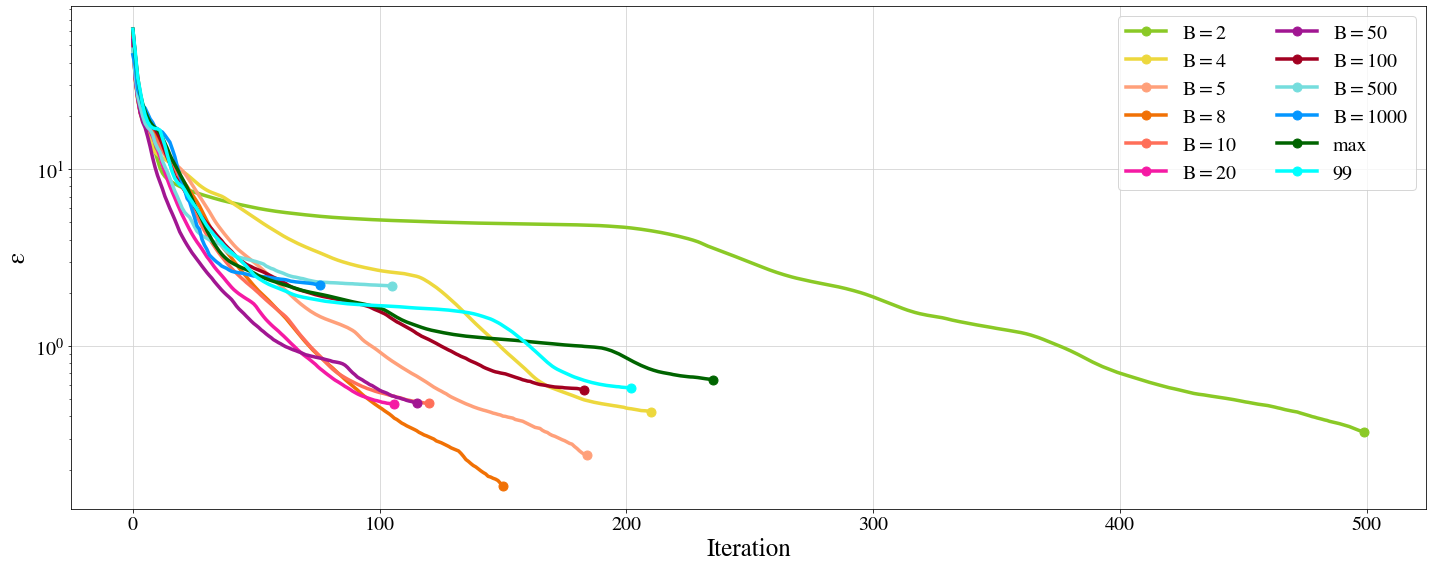

In [814]:
fig, ax = plt.subplots(figsize=(20,8))
#colors = ["#CBD081", '#20B2AA', '#FFA07A', "#FF6F59", "#A20021", "#153131", "#6A7FDB", "#FFAAEA", "#F51AA4", "#916C80"]
colors = ["#8AC926", "#EDD83D", '#FFA07A', "#F17105", "#FF6F59", "#F51AA4", "#A11692", "#A20021", "#75DDDD", "#0496FF"]
LW=3.5
MS=9
ax.plot(B2N25k_NEW.εs[1:], label=r'$\mathregular{B=2}$', lw=LW, color=colors[0], markevery=[-1], marker='o', markersize=MS)
ax.plot(B4N12500_NEW.εs[1:], label=r"$\mathregular{B=4}$", lw=LW, color=colors[1], markevery=[-1], marker='o', markersize=MS)
ax.plot(B5N10k.εs[1:], label=r"$\mathregular{B=5}$", lw=LW, color=colors[2], markevery=[-1], marker='o', markersize=MS)
ax.plot(B8N6250.εs[1:], label=r"$\mathregular{B=8}$", lw=LW, color=colors[3], markevery=[-1], marker='o', markersize=MS)
ax.plot(B10N5000.εs[1:], label=r"$\mathregular{B=10}$", lw=LW, color=colors[4], markevery=[-1], marker='o', markersize=MS)
ax.plot(B20N2500.εs[1:], label=r"$\mathregular{B=20}$", lw=LW, color=colors[5], markevery=[-1], marker='o', markersize=MS)
ax.plot(B50N1000.εs[1:], label=r"$\mathregular{B=50}$", lw=LW, color=colors[6], markevery=[-1], marker='o', markersize=MS)
ax.plot(KEEP_B_FIXED.εs[1:], label=r"$\mathregular{B=100}$", lw=LW, color=colors[7], markevery=[-1], marker='o', markersize=MS)
ax.plot(B500N100.εs[1:], label=r"$\mathregular{B=500}$", lw=LW, color=colors[8], markevery=[-1], marker='o', markersize=MS)
ax.plot(B1000N50.εs[1:], label=r"$\mathregular{B=1000}$", lw=LW, color=colors[9], markevery=[-1], marker='o', markersize=MS)
ax.plot(AB_AN_MAX.εs[1:], label="max", lw=LW, color='darkgreen', markevery=[-1], marker='o', markersize=MS)
ax.plot(AB_AN_99.εs[1:], label="99", lw=LW, color='cyan', markevery=[-1], marker='o', markersize=MS)
ax.set_yscale("log")
ax.set_xlabel("Iteration", fontsize=25)
ax.set_ylabel(r"$\mathregular{\epsilon}$", fontsize=25)
ax.tick_params(labelsize=20)
ax.grid(True, color='lightgray')
ax.legend(fontsize=20, ncol=2)
plt.tight_layout()
# plt.savefig("figures/gk20_epsilons_many_NB_combinations_samestart.png")
plt.show()

Plot all the other plots, for these algorithms

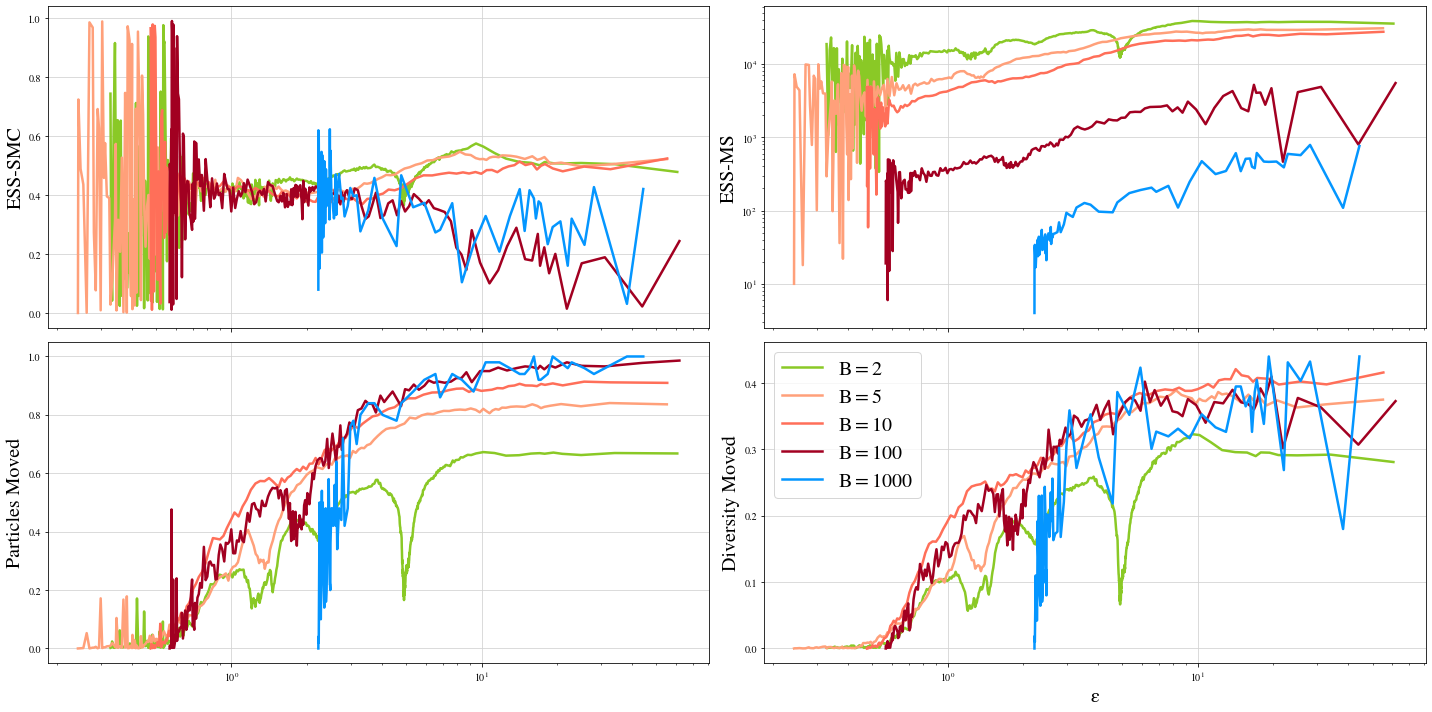

In [808]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)
FS=20
LFS=20
LW = 2.5
MS     = [B2N25k_NEW, B4N12500_NEW, B5N10k, B8N6250, B10N5000, B20N2500, B50N1000, KEEP_B_FIXED, B500N100, B1000N50]
BS     = np.array([2, 4, 5, 8, 10, 20, 50, 100, 500, 1000])
KEEP   = [0, 2, 4, 7, 9] # DETERMINES WHICH ONES TO KEEP
COLORS = ["#8AC926", "#EDD83D", '#FFA07A', "#F17105", "#FF6F59", "#F51AA4", "#A11692", "#A20021", "#75DDDD", "#0496FF"]

# ESS-SMC
for i in KEEP:
    ax[0, 0].plot(MS[i].εs[1:], np.array(MS[i].ESS_SMC[1:])/MS[i].N, label=r"$\mathregular{B=" + r"{}".format(BS[i]) + r"}$", lw=LW, color=COLORS[i])
ax[0, 0].set_xscale('log')
ax[0, 0].set_ylabel("ESS-SMC", fontsize=FS)
# ESS-MS
for i in KEEP:
    ax[0, 1].plot(MS[i].εs[1:], np.array(MS[i].ESS[1:]), label=r"$\mathregular{B=" + r"{}".format(BS[i]) + r"}$", lw=LW, color=COLORS[i])
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel("ESS-MS", fontsize=FS)
# PROPORTION OF PARTICLES MOVED OVER EPSILON
for i in KEEP:
    ax[1, 0].plot(MS[i].εs[1:], MS[i].PROP_MOVED[1:], label=r"$\mathregular{B=" + r"{}".format(BS[i]) + r"}$", lw=LW, color=COLORS[i])
ax[1, 0].set_xscale('log')
ax[1, 0].set_ylabel("Particles Moved", fontsize=FS)
# DIVERSITY MOVED
for i in KEEP:
    ax[1, 1].plot(MS[i].εs[1:], MS[i].DIV_MOVED[1:], label=r"$\mathregular{B=" + r"{}".format(BS[i]) + r"}$", lw=LW, color=COLORS[i])
ax[1, 1].set_xscale('log')
ax[1, 1].set_ylabel("Diversity Moved", fontsize=FS)
ax[1, 1].set_xlabel(r"$\mathregular{\epsilon}$", fontsize=FS)
for i in range(2):
    for j in range(2):
        ax[i, j].grid(True, color='lightgray')
plt.legend(fontsize=LFS)
plt.tight_layout()
plt.savefig("figures/gk20_various_metrics_for_NB_onlysome.png")
plt.show()

What are the $NBP$ values?

In [843]:
MS  = [B2N25k_NEW, B4N12500_NEW, B5N10k, B8N6250, B10N5000, B20N2500, B50N1000, KEEP_B_FIXED, B500N100, B1000N50]
NB  = []
NBP = []
EPSILON_OVER_N = []
OTHER = []
for ms in MS:
    NB.append(ms.N*ms.B)
    NBP.append(ms.N*ms.B*ms.n)
    EPSILON_OVER_N.append(ms.εs[-1] / ms.n)
    OTHER.append(ms.εs[-1]*ms.n*ms.B)
### THE SMALLEST EPSILON_OVER_N, THE BETTER
MS_BS = np.array([2, 4, 5, 8, 10, 20, 50, 100, 500, 1000])
# MS_BS[np.argsort(EPSILON_OVER_N)]

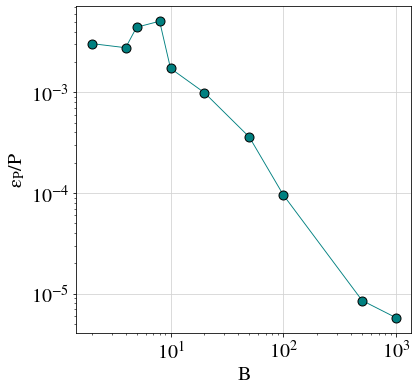

In [845]:
fig, ax = plt.subplots(figsize=(6,6))
ax.loglog()
ax.plot(MS_BS, 1/np.array(OTHER), lw=0.9, marker='o', markersize=9, color='teal', markeredgecolor='k', markeredgewidth=1)
ax.set_ylabel(r"$\mathregular{\epsilon_P / P}$", fontsize=20)
ax.set_xlabel(r"$\mathregular{B}$", fontsize=20)
ax.tick_params(labelsize=20)
ax.grid(True, color='lightgray')
# plt.savefig("figures/gk20_P_over_epsilonP.png")
plt.show()

Before I have run `AB_FN_MAX` which used `N=10\,000` and started with $B=100$.
Now I want to run the algorithm with `N=10\,000` and $B=100$.
I already have the result for `N=10\,000` and `B=5`.
The aim is to compare if the adaptive one can bridge between the two in some way

First, run one more time B5N10k with the right initial epsilon.

In [825]:
# KEEP IT FIXED, LARGE B, SMALL N
B5N10k_NEW = MSAdaptive(generate_settings(d=d, N=10000, B=5,
        δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B5N10k_NEW_PARTICLES = B5N10k_NEW.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.0069753305084248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8361000000000000
	Particle Diversity: 0.4485000000000000
	Moved Diversity: 0.3749908500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 32.5073596183209617
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8379000000000000
	Particle Diversity: 0.4389000000000000
	Moved Diversity: 0.3677543100000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.0770392405814775
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8275000000000000
	Particle Diversity: 0.4733000000000000
	Moved Diversity: 0.3916557500000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 8.1877005910732823
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8270999999999999
	Particle Diversity: 0.4683000000000000
	Moved Diversity: 0.3873309300000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 7.7362001565287821
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8162000000000000
	Particle Diversity: 0.4699000000000000
	Moved Diversity: 0.3835323800000000
	Step-size kept fixed at: 0.0100000000000000
I

	Epsilon: 3.6980245146504727
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7423000000000000
	Particle Diversity: 0.4357000000000000
	Moved Diversity: 0.3234201100000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.5573738138884075
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7411000000000000
	Particle Diversity: 0.4378000000000000
	Moved Diversity: 0.3244535800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.4276218613077911
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7363000000000000
	Particle Diversity: 0.4342000000000000
	Moved Diversity: 0.3197014599999999
	Step-size kept f

	Epsilon: 1.9228464980588864
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5541000000000000
	Particle Diversity: 0.4222000000000000
	Moved Diversity: 0.2339410200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8878366241652167
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5315000000000000
	Particle Diversity: 0.4298000000000000
	Moved Diversity: 0.2284387000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.8523600418788775
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.5349000000000000
	Particle Diversity: 0.4239000000000000
	Moved Diversity: 0.2267441100000000
	Step-size kept f

	Epsilon: 1.1310146353044077
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4244000000000000
	Particle Diversity: 0.4192000000000000
	Moved Diversity: 0.1779084800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.1014499685891739
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4294000000000000
	Particle Diversity: 0.4161000000000000
	Moved Diversity: 0.1786733400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0682079851343957
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4196000000000000
	Particle Diversity: 0.4186000000000000
	Moved Diversity: 0.1756445600000000
	Step-size kept f

	Epsilon: 0.5512731979672518
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1070000000000000
	Particle Diversity: 0.4243000000000000
	Moved Diversity: 0.0454001000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5400323587187349
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1170000000000000
	Particle Diversity: 0.3782000000000000
	Moved Diversity: 0.0442494000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5295236068198378
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.1208000000000000
	Particle Diversity: 0.3614000000000000
	Moved Diversity: 0.0436571200000000
	Step-size kept

	Epsilon: 0.3238715395068331
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0897000000000000
	Particle Diversity: 0.0843000000000000
	Moved Diversity: 0.0075617100000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  139
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3183583255029134
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0103000000000000
	Particle Diversity: 0.4686000000000000
	Moved Diversity: 0.0048265800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  140
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3140500533819577
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0126000000000000
	Particle Diversity: 0.4294000000000000
	Moved Diversity: 0.0054104400000000
	Step-size kept

	Epsilon: 0.2188766488425767
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0008000000000000
	Particle Diversity: 0.5869000000000000
	Moved Diversity: 0.0004695200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  162
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2148682202481831
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0796000000000000
	Particle Diversity: 0.0142000000000000
	Moved Diversity: 0.0011303200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  163
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2112405025405990
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0119000000000000
	Particle Diversity: 0.0841000000000000
	Moved Diversity: 0.0010007900000000
	Step-size kept

Next, run $N=10000$ and $B=100$

In [829]:
# KEEP IT FIXED, LARGE B, SMALL N
B100N10k = MSAdaptive(generate_settings(d=d, N=10000, B=100,
        δ=0.01, δmin=δmin, min_pm=(1/10000), verbose=True, εs_fixed=None, adaptiveε=True, adaptiveδ=False,
        z0_manual=SECOND_PARTICLES10k, pm_target=0.23, pm_switch=pm_switch, low_memory=True, integrator='rwm',
        εprop_switch=0.01, ε0_manual=200.0, quantile_value=0.5, initialization='manual',
        switch_strategy='pm', kernel='uniform',use_autograd=False, stopping_criterion={'εmin', 'pm', 'maxiter'},
        resampling_scheme='multinomial', maxiter=500, δadaptation_method=None, adaptiveB=False,
        Bmin=5, Bmax=100, proxy_ap_metric='pm', prop_esjd=0.95))
B100N10k_PARTICLES = B100N10k.sample()

Integrator: RWM.
Stopping criterion:  maxiter, εmin, pm.
Resampling: MULTINOMIAL.
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 55.0069753305084248
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9784000000000000
	Particle Diversity: 0.3567000000000000
	Moved Diversity: 0.3489952800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 33.2208086967043599
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9808000000000000
	Particle Diversity: 0.3301000000000000
	Moved Diversity: 0.3237620800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 25.3596165801775406
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Ve

	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8890000000000000
	Particle Diversity: 0.4079000000000000
	Moved Diversity: 0.3626231000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  24
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.9770224271934804
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8700000000000000
	Particle Diversity: 0.4156000000000000
	Moved Diversity: 0.3615720000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  25
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7776638030794079
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8673000000000000
	Particle Diversity: 0.4110000000000000
	Moved Diversity: 0.3564603000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  26
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon:

	Trajectories constructed.
	Epsilon: 1.5260136111338931
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6714000000000000
	Particle Diversity: 0.4268000000000000
	Moved Diversity: 0.2865535200000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  47
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4642498855035977
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6382000000000000
	Particle Diversity: 0.4322000000000000
	Moved Diversity: 0.2758300400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  48
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.4101337063018815
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.6289000000000000
	Particle Diversity: 0.4386000000000000
	Moved Diversity: 0.2758355

	Trajectories constructed.
	Epsilon: 0.7651950119468062
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4267000000000000
	Particle Diversity: 0.4364000000000000
	Moved Diversity: 0.1862118800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7347177479624606
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4032000000000000
	Particle Diversity: 0.4322000000000000
	Moved Diversity: 0.1742630400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7069993622398856
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3682000000000000
	Particle Diversity: 0.4384000000000000
	Moved Diversity: 0.1614188

	Trajectories constructed.
	Epsilon: 0.3953674535694525
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0538000000000000
	Particle Diversity: 0.4436000000000000
	Moved Diversity: 0.0238656800000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  93
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3866231595698701
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0439000000000000
	Particle Diversity: 0.4286000000000000
	Moved Diversity: 0.0188155400000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  94
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3770682410942092
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0333000000000000
	Particle Diversity: 0.4096000000000000
	Moved Diversity: 0.0136396

	Trajectories constructed.
	Epsilon: 0.2726503135870142
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0020000000000000
	Particle Diversity: 0.3138000000000000
	Moved Diversity: 0.0006276000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2708650714606903
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0010000000000000
	Particle Diversity: 0.6200000000000000
	Moved Diversity: 0.0006200000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.2691948022838812
	Weights computed and normalized.
	SMC Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0005000000000000
	Particle Diversity: 0.6319000000000000
	Moved Diversity: 0.00031

In [830]:
with open("experiment93/B100N10k_ess.pkl", "wb") as file:
    pickle.dump(B100N10k.ESS, file)
    
with open("experiment93/B100N10k_ess_smc.pkl", "wb") as file:
    pickle.dump(B100N10k.ESS_SMC, file)
    
with open("experiment93/B100N10k_epsilons.pkl", "wb") as file:
    pickle.dump(B100N10k.εs, file)
    
with open("experiment93/B100N10k_pm.pkl", "wb") as file:
    pickle.dump(B100N10k.PROP_MOVED, file)
    
with open("experiment93/B100N10k_pd.pkl", "wb") as file:
    pickle.dump(B100N10k.P_DIVERSITY, file)
    
with open("experiment93/B100N10k_dm.pkl", "wb") as file:
    pickle.dump(B100N10k.DIV_MOVED, file)

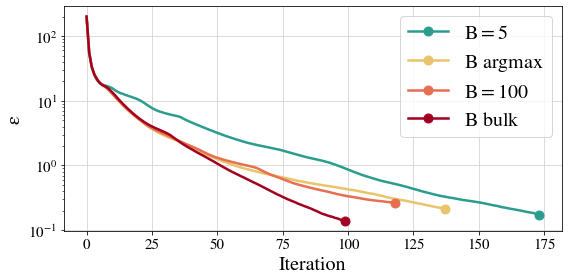

In [861]:
fig, ax = plt.subplots(figsize=(8, 4))
FS=20
LFS=20
LW = 2.5

ax.plot(B5N10k_NEW.εs, label=r"$\mathregular{B=" + r"{}".format(B5N10k_NEW.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#2A9D8F")
ax.plot(AB_FN_MAX.εs, label=r"$\mathregular{B}$" + " argmax", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E9C46A")
ax.plot(B100N10k.εs, label=r"$\mathregular{B=" + r"{}".format(B100N10k.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E76F51")
ax.plot(AB_FN_BULK99.εs, label=r"$\mathregular{B}$" + " bulk", lw=LW, markevery=[-1], marker='o', markersize=9, color='#A20021')
ax.set_yscale('log')
ax.set_ylabel(r"$\mathregular{\epsilon}$", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.tick_params(labelsize=15)
ax.grid(True, color='lightgray')
plt.legend(fontsize=LFS)
plt.tight_layout()
plt.savefig("figures/gk20_adaptiveB_similar_to_large_B_with_bulk.png")
plt.show()

How do I measure cost to show that in the above plot we are indeed performing better?

In [862]:
# A basic plot would be to show B

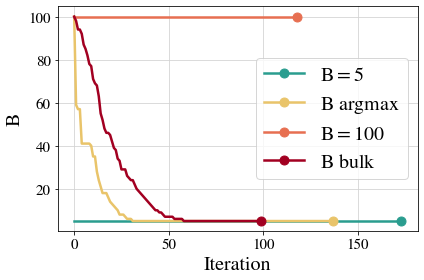

In [883]:
fig, ax = plt.subplots()
ax.plot(B5N10k_NEW.Bs*len(B5N10k_NEW.εs), label=r"$\mathregular{B=" + r"{}".format(B5N10k_NEW.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#2A9D8F")
ax.plot(AB_FN_MAX.Bs, label=r"$\mathregular{B}$" + " argmax", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E9C46A")
ax.plot(B100N10k.Bs*len(B100N10k.εs), label=r"$\mathregular{B=" + r"{}".format(B100N10k.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E76F51")
ax.plot(AB_FN_BULK99.Bs, label=r"$\mathregular{B}$" + " bulk", lw=LW, markevery=[-1], marker='o', markersize=9, color='#A20021')
ax.set_ylabel(r"$\mathregular{B}$", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.tick_params(labelsize=15)
ax.grid(True, color='lightgray')
plt.legend(fontsize=LFS)
plt.tight_layout()
plt.show()

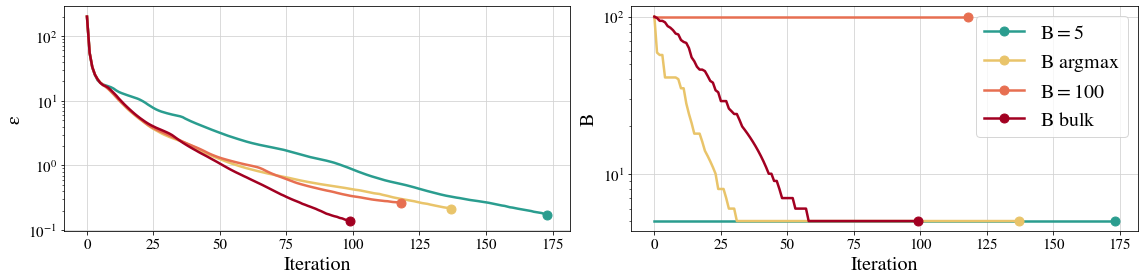

In [898]:
fig, ax = plt.subplots(figsize=(16, 4), ncols=2)
FS=20
LFS=20
LW = 2.5
### EPSILONS
ax[0].plot(B5N10k_NEW.εs, label=r"$\mathregular{B=" + r"{}".format(B5N10k_NEW.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#2A9D8F")
ax[0].plot(AB_FN_MAX.εs, label=r"$\mathregular{B}$" + " argmax", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E9C46A")
ax[0].plot(B100N10k.εs, label=r"$\mathregular{B=" + r"{}".format(B100N10k.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E76F51")
ax[0].plot(AB_FN_BULK99.εs, label=r"$\mathregular{B}$" + " bulk", lw=LW, markevery=[-1], marker='o', markersize=9, color='#A20021')
ax[0].set_yscale('log')
ax[0].set_ylabel(r"$\mathregular{\epsilon}$", fontsize=FS)
ax[0].set_xlabel("Iteration", fontsize=FS)
ax[0].tick_params(labelsize=15)
ax[0].grid(True, color='lightgray')
### BS
ax[1].plot(B5N10k_NEW.Bs*len(B5N10k_NEW.εs), label=r"$\mathregular{B=" + r"{}".format(B5N10k_NEW.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#2A9D8F")
ax[1].plot(AB_FN_MAX.Bs, label=r"$\mathregular{B}$" + " argmax", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E9C46A")
ax[1].plot(B100N10k.Bs*len(B100N10k.εs), label=r"$\mathregular{B=" + r"{}".format(B100N10k.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E76F51")
ax[1].plot(AB_FN_BULK99.Bs, label=r"$\mathregular{B}$" + " bulk", lw=LW, markevery=[-1], marker='o', markersize=9, color='#A20021')
ax[1].set_ylabel(r"$\mathregular{B}$", fontsize=FS)
ax[1].set_xlabel("Iteration", fontsize=FS)
ax[1].tick_params(labelsize=15)
ax[1].grid(True, color='lightgray')
ax[1].set_yscale('log')
# Prettify
plt.legend(fontsize=LFS)
plt.tight_layout()
plt.savefig("figures/gk20_adaptiveB_similar_to_large_B_with_bulk_twoplots.png")
plt.show()

How does this translate in terms of proportion of particles moved?

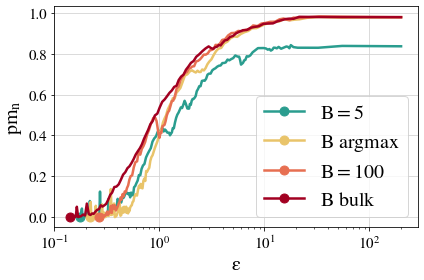

In [899]:
fig, ax = plt.subplots()
ax.plot(B5N10k_NEW.εs[:-1], B5N10k_NEW.PROP_MOVED[1:], label=r"$\mathregular{B=" + r"{}".format(B5N10k_NEW.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#2A9D8F")
ax.plot(AB_FN_MAX.εs[:-1], AB_FN_MAX.PROP_MOVED[1:], label=r"$\mathregular{B}$" + " argmax", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E9C46A")
ax.plot(B100N10k.εs[:-1], B100N10k.PROP_MOVED[1:], label=r"$\mathregular{B=" + r"{}".format(B100N10k.B) + r"}$", lw=LW, markevery=[-1], marker='o', markersize=9, color="#E76F51")
ax.plot(AB_FN_BULK99.εs[:-1], AB_FN_BULK99.PROP_MOVED[1:], label=r"$\mathregular{B}$" + " bulk", lw=LW, markevery=[-1], marker='o', markersize=9, color='#A20021')
ax.set_ylabel(r"$\mathregular{pm_n}$", fontsize=FS)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=FS)
ax.set_xscale("log")
ax.tick_params(labelsize=15)
ax.grid(True, color='lightgray')
plt.legend(fontsize=LFS)
plt.tight_layout()
plt.show()

In [942]:
np.cumsum(AB_FN_BULK99)

array([<__main__.MSAdaptive object at 0x32906faf0>], dtype=object)

In [940]:
B100N10k.ESJD_CHANG[1:].sum(axis=1).shape

(118,)

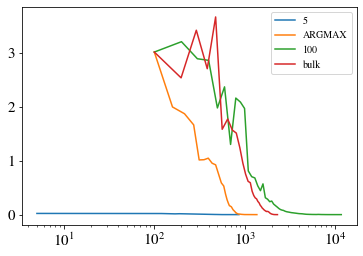

In [945]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(B5N10k_NEW.Bs*B5N10k_NEW.n)[:-1], B5N10k_NEW.ESJD_CHANG[1:].sum(axis=1), label='5')
ax.plot(np.cumsum(AB_FN_MAX.Bs)[:-1], np.array([np.sum(e) for e in AB_FN_MAX.ESJD_CHANG[1:]]), label='ARGMAX')
ax.plot(np.cumsum(B100N10k.Bs*B100N10k.n)[:-1], B100N10k.ESJD_CHANG[1:].sum(axis=1), label='100')
ax.plot(np.cumsum(AB_FN_BULK99.Bs)[:-1], np.array([np.sum(e) for e in AB_FN_BULK99.ESJD_CHANG[1:]]), label='bulk')
ax.legend()
ax.set_xscale('log')
ax.tick_params(labelsize=15)

This is not bad, but I want to somehow show $B$, $P$ and maybe $\epsilon$ at the same time.

In [888]:
B5N10k_NEW.B*B5N10k_NEW.n

870

In [890]:
sum(AB_FN_MAX.Bs)

1375

In [892]:
B100N10k.B * B100N10k.n

11900

In [895]:
sum(AB_FN_BULK99.Bs)

2320

In [975]:
np.apply_along_axis(SECOND_RUN10k.log_ηs[-1], 1, SECOND_PARTICLES10k[:, :d])

array([-142.78659741, -136.48867249, -138.23619077, ..., -136.78087374,
       -138.974572  , -136.25221036])

In [974]:
SECOND_RUN10k.log_ηs[-1](SECOND_PARTICLES10k[0, :d])

-142.7865974141428

In [973]:
exp(SECOND_RUN10k.manifold.logprior(SECOND_PARTICLES10k[0, :d]) + log(float(norm(SECOND_RUN10k.manifold.q(SECOND_PARTICLES10k[0, :d])) <= 200.0)) - SECOND_RUN10k.manifold.m*log(200.0))

9.740217465728908e-63